# Project Goals and Structure

This project analyses the causal impact of a marketing campaign on customer's retention and is structured in the following way:

1. Main Limitation
2. General Observations
3. Conclusions
4. Data health check: From cell 1 to 40 - I remove rows with missing values, outliers, and check correlation to see if I need to deal with some colinear columns
5. Exploratory data analysis: From cell 41 to 73 - I plot various features to see whether there are differences between treatment and control group, and between retention within these groups. I do t-tests and chi2 tests to see if there is treatment effect or effect on outcome.
6. Visual inspection of treated and outcome: From cell 74 to 123 - I am doing visual checks to see if the distributions of various features is similar for treatment and control group, looking for confounders, patterns, and insights for stakeholders.
7. Causal inference method: From cell 124 to 131 - I am testing various causal inference models to select the one fitting the data best, and comparing the result to the pre-matched model from the Visual Inspection section
8. Next steps

## Main Limitation
1. The features in the dataset we currently have show us the demographics and engagement of people who either saw the campaign or didn't and who were either retained or not. This allows us to measure the effect of the treatment to some extent, however, we need to look at the user behavior before and after the treatment to be able to say whether the actual campaign was successful or not. For example, what happened to user engagement after they were retained because of the campaign? Did their engagement improve or decline? We need to analyse this because of Goodhart's law - if a metric becomes a target then it becomes a bad metric. This means that we might fall into a trap of optmizing the campaign for retention __only__ when the real business goal would be to inform the user of something that will entice them to increase their engagement as well - get retained and stay. On the other hand, can we really say that the campaign successfully increased retention if the engagement of those users declines after the campaign? We need to compare before and after campaign user behavior

## General Observations
1. We remove all customers for whom we do not know whether they received the treatment or not
2. We remove all customers for whom we do not know whether they were retained or not
3. We remove 4 outliers with low or no income because they did not affect the spread of the rest of the columns but did affect the spread of the income column. Three of these outliers received the treatment, which is about 2% of all customers who received treatment

## Data Health Check

In [1]:
### Import the libraries we are using
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
from scipy.stats import fisher_exact
from scipy.stats import ttest_ind
from scipy import stats
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

In [2]:
### Set the look of the plots we are visualizing
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale = 1.2)

In [3]:
### Import the dataset we are analysing
df = pd.read_csv('data.csv', delimiter=';') 

In [4]:
df.head()

,Unnamed: 0,age,clv,segment,customer_engagement_score,treated,outcome,subscription_length,income,life_phase,gender,app_engagement_score
0,0,58.0,52.0,Segment 3,41.0,1.0,1.0,26.0,69965.0,A,Female,8.0
1,1,43.0,77.0,Segment 3,85.0,0.0,0.0,22.0,77891.0,B,Female,61.0
2,2,41.0,NaN,Segment 2,85.0,NaN,0.0,28.0,69466.0,A,Female,NaN
3,3,41.0,100.0,Segment 1,9.0,0.0,0.0,1.0,71099.0,A,Male,77.0
4,4,89.0,0.0,Segment 2,9.0,0.0,0.0,2.0,50438.0,C,Female,65.0


In [5]:
### Let's see if we need the index column at the start. Do we have duplicates or is every row a customer? Let's check
num_duplicates = df.duplicated().sum()

print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 0


In [6]:
### There are no duplicates, good. Let's remove the index column
df = df.drop(df.columns[0], axis=1)

In [7]:
### Let's first see if we have missing values and how to deal with them
df.isnull().sum()

age                          67
clv                          67
segment                      67
customer_engagement_score    67
treated                      67
outcome                      67
subscription_length          67
income                       67
life_phase                   67
gender                       67
app_engagement_score         67
dtype: int64

In [8]:
### Being aware that we are removing user behavior that could be helpful in our analysis, we are going to remove customers with null values 
### in their "treated" column. Perhaps we can try to use a method on these users to infer their missing values, but this might introduce 
### biases in the causal inference analysis. We leave this for additional experimentation

df = df.dropna(subset=['treated'])

In [9]:
### Let's see what that did to the missing values
df.isnull().sum()

age                          63
clv                          65
segment                      65
customer_engagement_score    64
treated                       0
outcome                      64
subscription_length          62
income                       62
life_phase                   63
gender                       67
app_engagement_score         64
dtype: int64

In [10]:
### It seems like removing the customers with no known treatment values removed very little null values of the rest of the columns.
### We need to remove the customers with unknown outcome as well, because we don't know if they were retained or not and we can't
### assign their behavior to anything

df = df.dropna(subset=['outcome'])

In [11]:
### Let's see what that did to the missing values
df.isnull().sum()

age                          60
clv                          62
segment                      65
customer_engagement_score    61
treated                       0
outcome                       0
subscription_length          58
income                       59
life_phase                   59
gender                       63
app_engagement_score         62
dtype: int64

In [12]:
### At this point, we have a few choices: 1) we can impute the missing values or we can delete them. To know what to do, 
### let's see which group the customers with the null values belong to: treated or not, retained or not:

# Group by 'treated' and 'outcome', and then count the null values for each column
columns_to_check = ['age', 'clv', 'segment', 'customer_engagement_score', 'subscription_length', 'income', 'life_phase', 'gender', 'app_engagement_score']
null_values_by_treatment_outcome = df.groupby(['treated', 'outcome'])[columns_to_check].apply(lambda x: x.isnull().sum())

In [13]:
null_values_by_treatment_outcome

age  clv  segment  customer_engagement_score  \
treated outcome                                                 
0.0     0.0       39   40       41                         48   
        1.0        8    9       12                          8   
1.0     0.0        2    5        5                          2   
        1.0       11    8        7                          3   

                 subscription_length  income  life_phase  gender  \
treated outcome                                                    
0.0     0.0                       46      43          42      52   
        1.0                        5       8           7       7   
1.0     0.0                        1       5           0       4   
        1.0                        6       3          10       0   

                 app_engagement_score  
treated outcome                        
0.0     0.0                        41  
        1.0                        11  
1.0     0.0                         2  
        1.0                         8

In [14]:
### It looks like the majority of the null values in all columns are for customers who did not see the marketing campaign
### and were not retained. However, these absolute numbers may be misleading, so let's compare the numbers to customers
### that do not have missing values

values_by_treatment_outcome = df.groupby(['treated', 'outcome'])[columns_to_check].apply(lambda x: x.count())

In [15]:
values_by_treatment_outcome

age  clv  segment  customer_engagement_score  \
treated outcome                                                 
0.0     0.0      797  796      795                        788   
        1.0      151  150      147                        151   
1.0     0.0       57   54       54                         57   
        1.0      141  144      145                        149   

                 subscription_length  income  life_phase  gender  \
treated outcome                                                    
0.0     0.0                      790     793         794     784   
        1.0                      154     151         152     152   
1.0     0.0                       58      54          59      55   
        1.0                      146     149         142     152   

                 app_engagement_score  
treated outcome                        
0.0     0.0                       795  
        1.0                       148  
1.0     0.0                        57  
        1.0                       144

In [16]:
### We can see a couple of things from this table: 1) there are many more not treated and not retained customers than
### any other segment; 2) when customers saw the campaign, they were more often retained than not. 

In [17]:
### However, since the number of missing values for both treated and not treated customers is relatively low
### (39 + 8) / (797 / 151) = 5%, and (2 + 11) / (57 + 141) = 6.5%, we are going to remove the customers who have null values
### in the rest of the columns as well. We are aware that these users might have behavior we can analyse but we want to
### first analyse the causal impact with a clean dataset and leave the imputing exercises for future experimentation

df = df.dropna()

In [18]:
df.head()

,age,clv,segment,customer_engagement_score,treated,outcome,subscription_length,income,life_phase,gender,app_engagement_score
0,58.0,52.0,Segment 3,41.0,1.0,1.0,26.0,69965.0,A,Female,8.0
1,43.0,77.0,Segment 3,85.0,0.0,0.0,22.0,77891.0,B,Female,61.0
3,41.0,100.0,Segment 1,9.0,0.0,0.0,1.0,71099.0,A,Male,77.0
4,89.0,0.0,Segment 2,9.0,0.0,0.0,2.0,50438.0,C,Female,65.0
5,65.0,17.0,Segment 3,26.0,0.0,0.0,17.0,61400.0,A,Female,21.0


In [19]:
### In our analyses later, we might need to encode the categorical variables and/or normalize the numerical variables
### since most numerical variables are on a similar scale but income is on a different one.
### For now, let's continue our health check and look for outliers

In [20]:
### First, let's see the spread of the numerical columns. If we don't specify the columns, df.describe() will calculate the std
### for treated and outcome, and that's just silly :) 

numerical_columns = ['age', 'clv', 'customer_engagement_score', 'subscription_length', 'income', 'app_engagement_score']
df[numerical_columns].describe()

,age,clv,customer_engagement_score,subscription_length,income,app_engagement_score
count,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000
mean,50.279101,63.923280,48.882275,17.927249,61006.507937,50.670635
std,20.694054,34.747558,28.557703,9.976861,19844.717647,28.814111
min,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,34.000000,39.000000,24.750000,9.000000,49078.500000,26.000000
50%,47.000000,77.000000,49.000000,18.000000,64951.000000,53.000000
75%,63.000000,94.000000,74.000000,26.000000,76189.000000,75.000000
max,100.000000,100.000000,99.000000,35.000000,102800.000000,99.000000


In [21]:
## Let's do a z-score check for outliers. If the z-score > 3, the point is an outlier
z_scores = np.abs(zscore(df[numerical_columns]))

In [22]:
# If threshold is greater than 3, it's an outlier
threshold = 3

# Identify outliers
outliers = (z_scores > threshold)

In [23]:
# Count the number of outliers in each feature
num_outliers_per_feature = np.sum(outliers, axis=0)

# We store the number of outliers per feature and the feature in a dictionary
outliers_summary = pd.DataFrame({
    'Feature': df[numerical_columns].columns,
    'Number_of_Outliers': num_outliers_per_feature,
    'Percentage_of_Outliers': (num_outliers_per_feature / len(df)) * 100
})

print(outliers_summary)

                                             Feature  Number_of_Outliers  \
age                                              age                   0   
clv                                              clv                   0   
customer_engagement_score  customer_engagement_score                   0   
subscription_length              subscription_length                   0   
income                                        income                   4   
app_engagement_score            app_engagement_score                   0   

                           Percentage_of_Outliers  
age                                      0.000000  
clv                                      0.000000  
customer_engagement_score                0.000000  
subscription_length                      0.000000  
income                                   0.529101  
app_engagement_score                     0.000000  


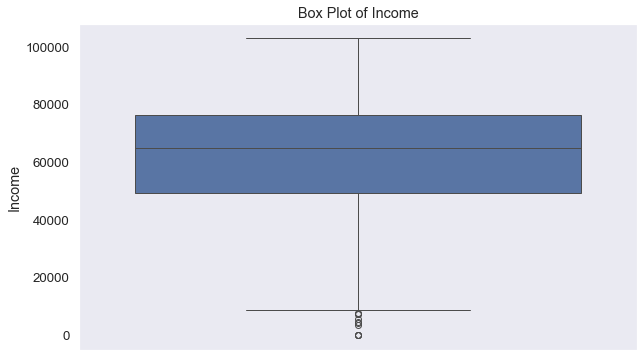

In [24]:
### We seem to have found customers that have irregular incomes. Let's first visualize them and then see if we need to
### remove them
plt.figure(figsize=(10, 6))
sns.boxplot(y=df['income'])
plt.title('Box Plot of Income')
plt.ylabel('Income')
plt.grid(axis='y')
plt.show()

In [25]:
### These customers seem to have very low income. Let's isolate them and look at them
df[df['income'] < 200]

,age,clv,segment,customer_engagement_score,treated,outcome,subscription_length,income,life_phase,gender,app_engagement_score
9,18.0,56.0,Segment 1,10.0,1.0,0.0,11.0,0.0,C,Male,32.0
394,26.0,87.0,Segment 1,19.0,1.0,0.0,13.0,0.0,C,Female,97.0
783,19.0,50.0,Segment 3,46.0,0.0,0.0,6.0,0.0,B,Male,67.0
814,18.0,54.0,Segment 3,90.0,1.0,0.0,17.0,123.0,A,Female,16.0


In [26]:
### How many treated users do we total?
len(df[df['treated'] == 1])

141

In [27]:
### 3 treated out of 141 is about 2%, but let's see a few more things

In [28]:
### It looks like these customers are very young and that's why they may not have income (or a low one). Even though they
### are not retained, at least two of them are either somewhat or very engaged, let's compare them to their similar age cohort

df[df['age'] <= 26][numerical_columns].describe()

,age,clv,customer_engagement_score,subscription_length,income,app_engagement_score
count,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000
mean,21.375000,64.806818,49.750000,17.693182,26880.409091,52.386364
std,2.797012,12.797142,28.496118,9.613637,14873.687653,30.871790
min,18.000000,41.000000,0.000000,1.000000,0.000000,0.000000
25%,18.000000,53.000000,24.000000,11.000000,17033.750000,22.750000
50%,22.000000,66.500000,50.000000,16.000000,26501.000000,56.500000
75%,24.000000,74.250000,74.250000,26.000000,35880.000000,80.250000
max,26.000000,91.000000,99.000000,35.000000,60475.000000,99.000000


In [29]:
### Later on we are going to test for confounders, since age and income are related

In [30]:
### Let's see how this changes if we remove the outliers
df[(df['age'] <= 26) & (df['income'] > 200)][numerical_columns].describe()

,age,clv,customer_engagement_score,subscription_length,income,app_engagement_score
count,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000
mean,21.428571,64.952381,50.154762,17.976190,28158.964286,52.357143
std,2.756310,12.677563,28.299812,9.712712,13981.816780,30.846156
min,18.000000,41.000000,0.000000,1.000000,3382.000000,0.000000
25%,18.750000,53.000000,25.500000,11.750000,17515.500000,22.750000
50%,22.000000,67.500000,51.500000,16.000000,27469.500000,56.500000
75%,24.000000,74.250000,74.250000,26.250000,36381.500000,80.250000
max,26.000000,91.000000,99.000000,35.000000,60475.000000,99.000000


In [31]:
### The spread of income changes significantly but there isn't much movement in the rest of the columns

In [32]:
### Let's now do some helpful visualizations, like histograms, boxplots, and correlation matrix. 
### We are first going to plot histograms and boxplots on the entire dataset and later check the treatment/control groups separately
### For the correlation matrix, we are going to do encoding on the categorical columns: label encode the gender variable because there
### are only two values, and one-hot encode the segment and life phase

### We are going to copy the dataset because we are encoding to check the correlation
df_corr = df.copy()

# Let's initialize LabelEncoder
le_gender = LabelEncoder()
# And do label encoding on gender
df_corr['gender'] = le_gender.fit_transform(df_corr['gender'])

In [33]:
### One-hot encode segment and life phase. We are one-hot encoding and not label-encoding because we assume there is no
### ordinal relationship between the values, merely categorization. This is why we don't merely extract the integer from 
### the segment values, they will become ordinal


In [34]:
df_corr = pd.get_dummies(df_corr, columns=['life_phase'], prefix=['life_phase'], prefix_sep='_')
df_corr = pd.get_dummies(df_corr, columns=['segment'], prefix='', prefix_sep='')

In [35]:
### A little tidying because the columns' names trigger OCD unnecessarily
df_corr.columns = df_corr.columns.str.lower()

### add underscore in the segments for the same reason
df_corr.columns = df_corr.columns.str.replace(' ', '_')

In [36]:
df_corr.head()

,age,clv,customer_engagement_score,treated,outcome,subscription_length,income,gender,app_engagement_score,life_phase_a,life_phase_b,life_phase_c,segment_1,segment_2,segment_3
0,58.0,52.0,41.0,1.0,1.0,26.0,69965.0,0,8.0,True,False,False,False,False,True
1,43.0,77.0,85.0,0.0,0.0,22.0,77891.0,0,61.0,False,True,False,False,False,True
3,41.0,100.0,9.0,0.0,0.0,1.0,71099.0,1,77.0,True,False,False,True,False,False
4,89.0,0.0,9.0,0.0,0.0,2.0,50438.0,0,65.0,False,False,True,False,True,False
5,65.0,17.0,26.0,0.0,0.0,17.0,61400.0,0,21.0,True,False,False,False,False,True


In [37]:
### Let's drop one of each encoded variables
df_corr = df_corr.drop(columns=['life_phase_c', 'segment_3'])

In [38]:
### We can now show the correlation matrix and prepare to be amazed

corr = df_corr.corr()

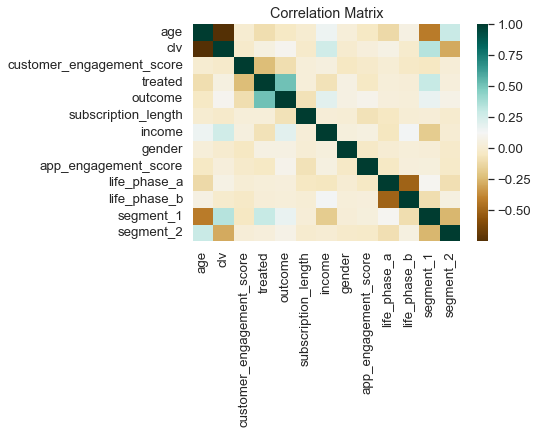

In [39]:
## Plot the correlation map
sns.heatmap(corr,cmap='BrBG')
plt.title('Correlation Matrix')
plt.show()

In [40]:
### Interesting, this seems to suggest there is some correlation between treated and outcome, which we also saw earlier. Treated is also 
### slightly correlated with segment_1. Age and customer value are negatively related; age seems to be positively correlated to segment_2
### but negatively related to segment_1, but curiosly, customer value seems to be slightly correlated to segment_1 and slightly negatively
### correlated to segment_2. Let's see this in a table

corr

,age,clv,customer_engagement_score,treated,outcome,subscription_length,income,gender,app_engagement_score,life_phase_a,life_phase_b,segment_1,segment_2
age,1.000000,-0.749150,0.000739,-0.095299,-0.044346,-0.000011,0.155652,0.027153,-0.039826,-0.116026,0.058433,-0.418730,0.295739
clv,-0.749150,1.000000,-0.022266,0.056899,0.098652,-0.019318,0.263230,-0.007171,0.033285,0.067655,-0.017135,0.340936,-0.286598
customer_engagement_score,0.000739,-0.022266,1.000000,-0.234224,-0.099872,0.024371,0.044685,-0.049905,-0.018812,0.011783,-0.037041,-0.048838,0.020059
treated,-0.095299,0.056899,-0.234224,1.000000,0.513497,0.026655,-0.076850,0.062936,-0.043112,0.023263,0.021799,0.300485,0.033784
outcome,-0.044346,0.098652,-0.099872,0.513497,1.000000,-0.075028,0.194266,0.058959,0.088925,0.031299,0.023586,0.166803,0.076360
subscription_length,-0.000011,-0.019318,0.024371,0.026655,-0.075028,1.000000,0.017207,0.013638,-0.074428,-0.046695,0.012391,0.018732,-0.009332
income,0.155652,0.263230,0.044685,-0.076850,0.194266,0.017207,1.000000,0.038270,0.052861,-0.052880,0.134517,-0.180499,0.008082
gender,0.027153,-0.007171,-0.049905,0.062936,0.058959,0.013638,0.038270,1.000000,-0.035899,0.004402,0.022961,0.022781,-0.021489
app_engagement_score,-0.039826,0.033285,-0.018812,-0.043112,0.088925,-0.074428,0.052861,-0.035899,1.000000,-0.043531,0.033943,0.039005,-0.026561
life_phase_a,-0.116026,0.067655,0.011783,0.023263,0.031299,-0.046695,-0.052880,0.004402,-0.043531,1.000000,-0.504920,0.109976,-0.086417


## Exploratory Data Analysis

In [41]:
### Let's investigate confounders. Even though there seem to be no strong correlations in variables that affect both 
### treated and outcome, correlation only takes in consideration linear relationships, and some variables may interact in a way
### that's complex for a correlation matrix to show. 

In [42]:
### Let's first see boxplots for treated and control group
treatment_group = df[df['treated'] == 1]
control_group = df[df['treated'] == 0]

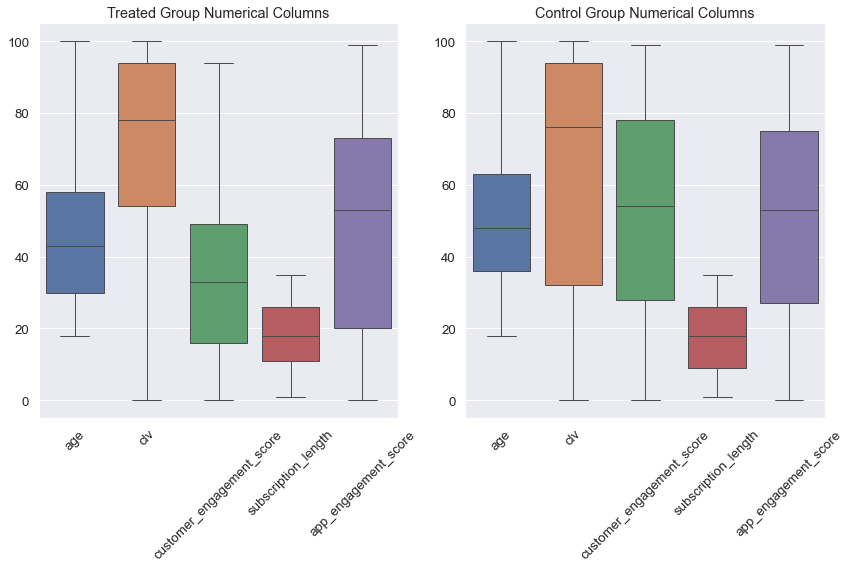

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))  

# Box plot for treated 
sns.boxplot(ax=axes[0],data=treatment_group[['age', 'clv', 'customer_engagement_score', 'subscription_length', 'app_engagement_score']])
## we specify the columns because #income has a different scale and will squeesh the rest of the plots
axes[0].set_title('Treated Group Numerical Columns')
plt.setp(axes[0].get_xticklabels(), rotation=45)

# Box plot for control
sns.boxplot(ax=axes[1], data=control_group[['age', 'clv', 'customer_engagement_score', 'subscription_length', 'app_engagement_score']])
axes[1].set_title('Control Group Numerical Columns')
plt.setp(axes[1].get_xticklabels(), rotation=45)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

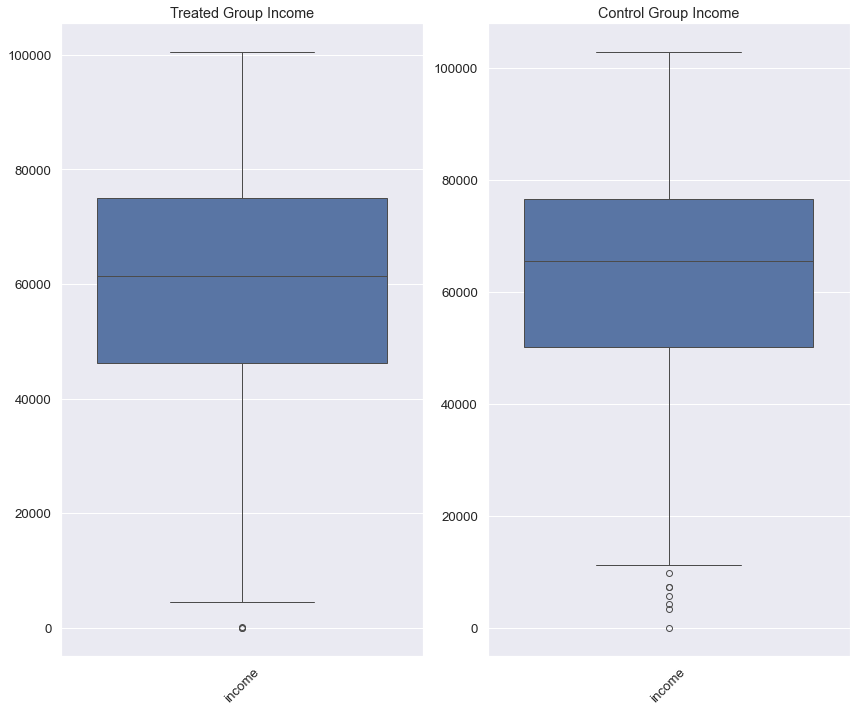

In [44]:
### Let's see income for both groups
fig, axes = plt.subplots(1, 2, figsize=(12, 10))  

# Box plot for treated 
sns.boxplot(ax=axes[0],data=treatment_group[['income']])
axes[0].set_title('Treated Group Income')
plt.setp(axes[0].get_xticklabels(), rotation=45)

# Box plot for control
sns.boxplot(ax=axes[1], data=control_group[['income']])
axes[1].set_title('Control Group Income')
plt.setp(axes[1].get_xticklabels(), rotation=45)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

In [45]:
### There are some differences between the clv and customer engagement score in the treatment and control group.
### Let's first see retained vs not retained customers
retained = df[df['outcome'] == 1]
not_retained = df[df['outcome'] == 0]

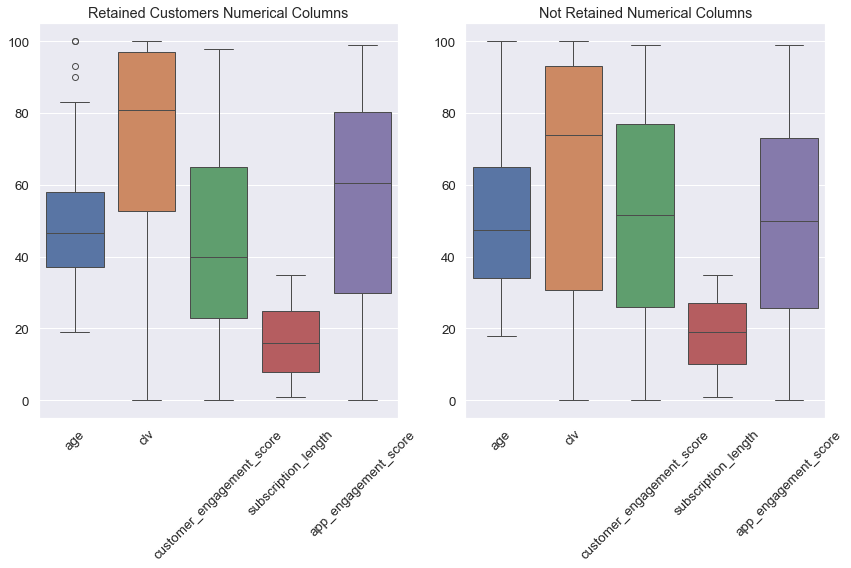

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))  

# Box plot for retained
sns.boxplot(ax=axes[0],data=retained[['age', 'clv', 'customer_engagement_score', 'subscription_length', 'app_engagement_score']])
axes[0].set_title('Retained Customers Numerical Columns')
plt.setp(axes[0].get_xticklabels(), rotation=45)

# Box plot for not retained
sns.boxplot(ax=axes[1], data=not_retained[['age', 'clv', 'customer_engagement_score', 'subscription_length', 'app_engagement_score']])
axes[1].set_title('Not Retained Numerical Columns')
plt.setp(axes[1].get_xticklabels(), rotation=45)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

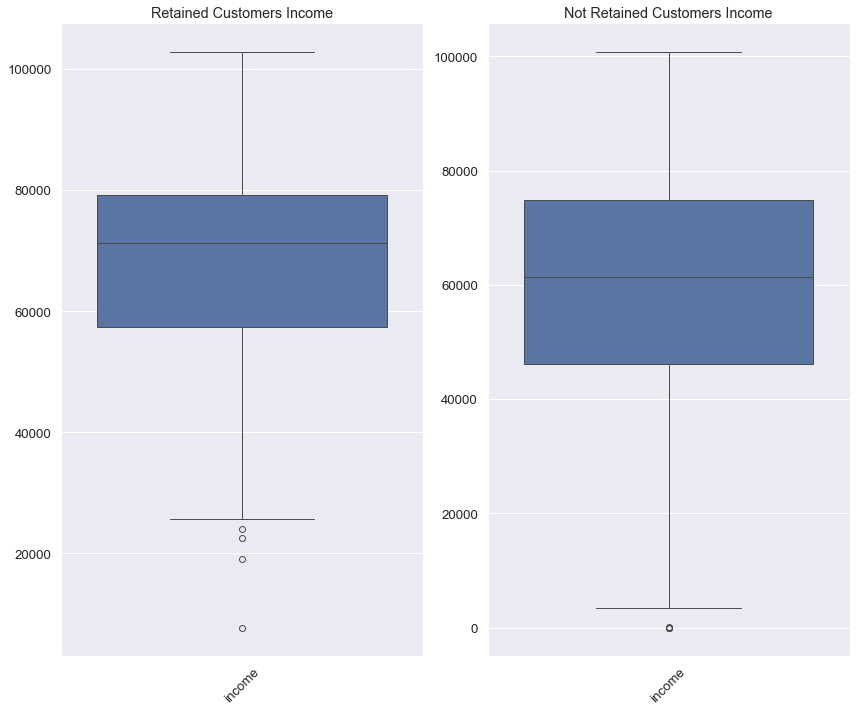

In [47]:
### Let's see income for both groups
fig, axes = plt.subplots(1, 2, figsize=(12, 10))  

# Box plot for retained 
sns.boxplot(ax=axes[0],data=retained[['income']])
axes[0].set_title('Retained Customers Income')
plt.setp(axes[0].get_xticklabels(), rotation=45)

# Box plot for not retained
sns.boxplot(ax=axes[1], data=not_retained[['income']])
axes[1].set_title('Not Retained Customers Income')
plt.setp(axes[1].get_xticklabels(), rotation=45)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

In [48]:
### Treated and outcome show similar behavior for clv and customer engagement score. Let's go further and check
### treated retained, treated not retained, not treated retained, and not treated not retained.

treated_retained = treatment_group[treatment_group['outcome'] == 1]
treated_not_retained = treatment_group[treatment_group['outcome'] == 0]
control_retained = control_group[control_group['outcome'] == 1]
control_not_retained = control_group[control_group['outcome'] == 0]

groups = [treated_retained, treated_not_retained, control_retained, control_not_retained]

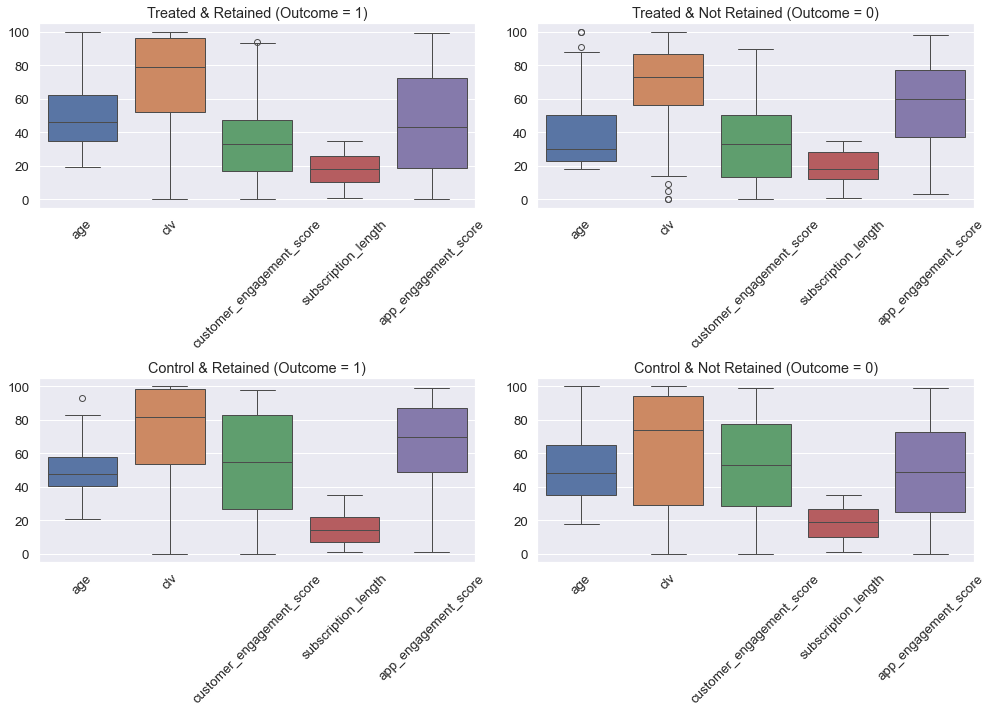

In [49]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2 rows, 2 columns, adjust the figsize as needed

# Box plot for treated & retained (outcome = 1)
sns.boxplot(ax=axes[0, 0],data=treated_retained[['age', 'clv', 'customer_engagement_score', 'subscription_length', 'app_engagement_score']])
axes[0, 0].set_title('Treated & Retained (Outcome = 1)')
plt.setp(axes[0, 0].get_xticklabels(), rotation=45)

# Box plot for treated & not retained (outcome = 0)
sns.boxplot(ax=axes[0, 1], data=treated_not_retained[['age', 'clv', 'customer_engagement_score', 'subscription_length', 'app_engagement_score']])
axes[0, 1].set_title('Treated & Not Retained (Outcome = 0)')
plt.setp(axes[0, 1].get_xticklabels(), rotation=45)

# Box plot for not treated & retained (outcome = 1)
sns.boxplot(ax=axes[1, 0], data=control_retained[['age', 'clv', 'customer_engagement_score', 'subscription_length', 'app_engagement_score']])
axes[1, 0].set_title('Control & Retained (Outcome = 1)')
plt.setp(axes[1, 0].get_xticklabels(), rotation=45)

# Box plot for not treated & not retained (outcome = 0)
sns.boxplot(ax=axes[1, 1], data=control_not_retained[['age', 'clv', 'customer_engagement_score', 'subscription_length', 'app_engagement_score']])
axes[1, 1].set_title('Control & Not Retained (Outcome = 0)')
plt.setp(axes[1, 1].get_xticklabels(), rotation=45)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

In [50]:
### Interesting, the treated groups have a smaller range of customer engagement score and it's lower than the not treated groups.
### Also, the variance is higher in the not treated group.

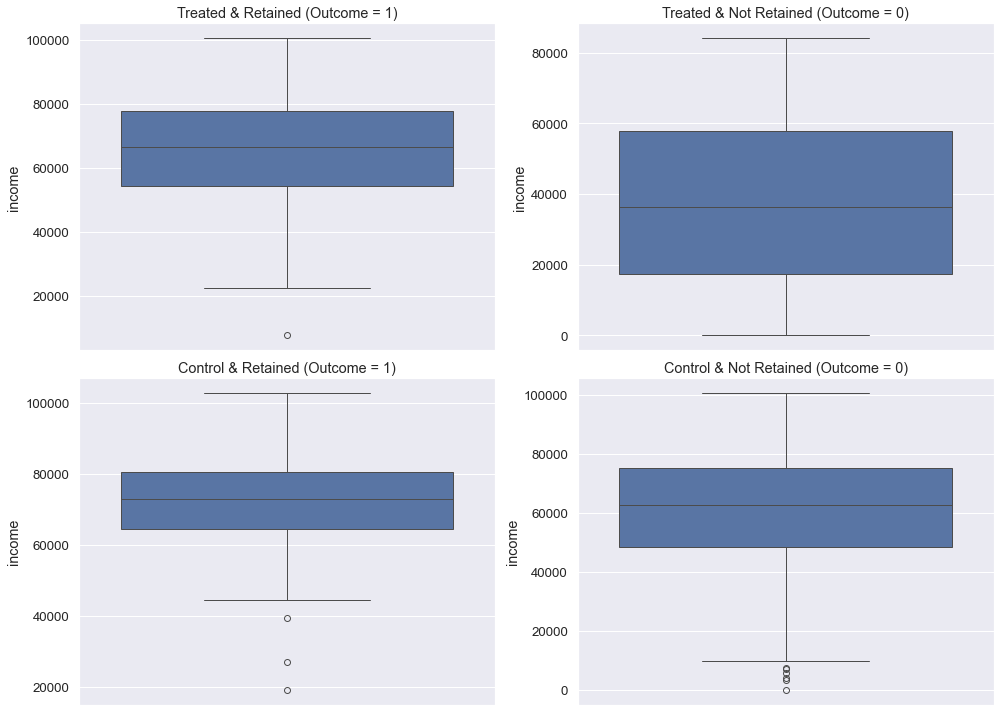

In [51]:
### Let's see income
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2 rows, 2 columns, adjust the figsize as needed

# Box plot for treated & retained (outcome = 1)
sns.boxplot(ax=axes[0, 0],data=treated_retained['income'])
axes[0, 0].set_title('Treated & Retained (Outcome = 1)')
plt.setp(axes[0, 0].get_xticklabels(), rotation=45)

# Box plot for treated & not retained (outcome = 0)
sns.boxplot(ax=axes[0, 1], data=treated_not_retained['income'])
axes[0, 1].set_title('Treated & Not Retained (Outcome = 0)')
plt.setp(axes[0, 1].get_xticklabels(), rotation=45)

# Box plot for not treated & retained (outcome = 1)
sns.boxplot(ax=axes[1, 0], data=control_retained['income'])
axes[1, 0].set_title('Control & Retained (Outcome = 1)')
plt.setp(axes[1, 0].get_xticklabels(), rotation=45)

# Box plot for not treated & not retained (outcome = 0)
sns.boxplot(ax=axes[1, 1], data=control_not_retained['income'])
axes[1, 1].set_title('Control & Not Retained (Outcome = 0)')
plt.setp(axes[1, 1].get_xticklabels(), rotation=45)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

In [52]:
### Interesting, income has a lower mean and more spread for one segment - Treated and Not Retained. Could the price
### of the product have affected these people's decision? We can investigate

In [53]:
### Let's quantify if these differences are meaningful. We are going to use t-test because treated is a binary column

# Dictionary to store results
t_test_results = {}

# Perform t-tests for each numerical column
for column in numerical_columns:
    treated_values = treatment_group[column]
    control_values = control_group[column]
    
    # Conduct the t-test
    t_stat, p_value = ttest_ind(treated_values, control_values, equal_var=False)  
    
    # Store the results
    t_test_results[column] = {
        't_statistic': round(t_stat, 2),
        'p_value': round(p_value, 2)
    }

# Create a dataframe so we can see results better
results_df = pd.DataFrame(t_test_results).T  
results_df['significant'] = results_df['p_value'] < 0.05  # If < than 0.05, flag as true

# Print the results
print(results_df)

                           t_statistic  p_value  significant
age                              -2.67     0.01         True
clv                               1.67     0.10        False
customer_engagement_score        -7.44     0.00         True
subscription_length               0.73     0.47        False
income                           -1.89     0.06        False
app_engagement_score             -1.15     0.25        False


In [54]:
### Interesting, the t-test is significant for age and customer engagement score, and the t-statistic negative values
### indicate that the treatment group has lower average age and lower average customer engagement score

In [55]:
### Is this the same for outcome?
### Let's quantify if these differences are meaningful. We are going to use t-test because treated is a binary column

# Dictionary to store results
t_test_results_outcome = {}

# Perform t-tests for each numerical column
for column in numerical_columns:
    retained_values = retained[column]
    not_retained_values = not_retained[column]
    
    # Conduct the t-test
    t_stat, p_value = ttest_ind(retained_values, not_retained_values, equal_var=False)  
    
    # Store the results
    t_test_results_outcome[column] = {
        't_statistic': round(t_stat, 2),
        'p_value': round(p_value, 2)
    }

# Create a dataframe so we can see results better
results_df = pd.DataFrame(t_test_results_outcome).T  
results_df['significant'] = results_df['p_value'] < 0.05  

# Print the results
print(results_df)

                           t_statistic  p_value  significant
age                              -1.41     0.16        False
clv                               2.85     0.00         True
customer_engagement_score        -2.81     0.01         True
subscription_length              -2.04     0.04         True
income                            6.07     0.00         True
app_engagement_score              2.38     0.02         True


In [56]:
### Interesting, this seems to indicate that all columns but age might affect retention 

In [57]:
### However, since we have indication that the treatment itself can influence retention, let's break treatment and control
### groups into four segments and do pair-wise t-tests to see whether the columns affect all segments:
### treated_retained, treated_not_retained, control_retained, control_not_retained

In [58]:
### Let's check the four segments we created

# Store results of t-tests 
t_test_results = []

# Do pair-wise t-tests between two groups
def run_t_test(var, group1, group2, name1, name2):
    t_stat, p_val = stats.ttest_ind(group1[var], group2[var])
    return {'Variable': var, 'Group1': name1, 'Group2': name2, 'T-Statistic': t_stat, 'P-Value': p_val}

# Compare each pair of segments
for var in numerical_columns:
    t_test_results.append(run_t_test(var, treated_retained, treated_not_retained, 'treated_retained', 'treated_not_retained'))
    t_test_results.append(run_t_test(var, treated_retained, control_retained, 'treated_retained', 'control_retained'))
    t_test_results.append(run_t_test(var, treated_retained, control_not_retained, 'treated_retained', 'control_not_retained'))
    t_test_results.append(run_t_test(var, treated_not_retained, control_retained, 'treated_not_retained', 'control_retained'))
    t_test_results.append(run_t_test(var, treated_not_retained, control_not_retained, 'treated_not_retained', 'control_not_retained'))
    t_test_results.append(run_t_test(var, control_retained, control_not_retained, 'control_retained', 'control_not_retained'))

t_test_results_df = pd.DataFrame(t_test_results)

# Format the t-statistic and p-value to 2 decimal places
t_test_results_df['T-Statistic'] = t_test_results_df['T-Statistic'].round(2)
t_test_results_df['P-Value'] = t_test_results_df['P-Value'].round(2)

# We store the significance of the value in a column
t_test_results_df['Significant'] = t_test_results_df['P-Value'] < 0.05

# We sort by significant so we can quickly spot the significant features first
t_test_results_df = t_test_results_df.sort_values(by='Significant', ascending=False)

# Show the results
print(t_test_results_df)

                     Variable                Group1                Group2  \
0                         age      treated_retained  treated_not_retained   
14  customer_engagement_score      treated_retained  control_not_retained   
31       app_engagement_score      treated_retained      control_retained   
29                     income      control_retained  control_not_retained   
28                     income  treated_not_retained  control_not_retained   
27                     income  treated_not_retained      control_retained   
26                     income      treated_retained  control_not_retained   
25                     income      treated_retained      control_retained   
24                     income      treated_retained  treated_not_retained   
23        subscription_length      control_retained  control_not_retained   
21        subscription_length  treated_not_retained      control_retained   
19        subscription_length      treated_retained      control_retained   

In [59]:
### We have 2 effects: 
### 1. Treatment effect - treatment vs control. Here we look at:
###    1. 1. treated_retained vs. treated_not retained, or
###    1. 2. control_retained vs control_not_retained, so here significant columns are:
###    age, income, subscription_length, app_engagement_score, and clv
### 2. Effect on retention - outcome within treatment group. Here we look at:
###    2. 1. treated_retained vs. control_retained, or
###    2. 2. treated_not_retained vs control_not_retained, so here significant columns are:
###    age, income, subscription_length, app_engagement_score, customer_engagement_score


In [60]:
### Interesting, age, income, subscription length and app engagement score have both treatment effect and effect on retention.
### Did we just find our confounders? (small yay)

In [61]:
### Let's see what is going on with the categorical variables
# First check treatment group
crosstab_result_treated = pd.crosstab(index=[treatment_group['segment'], treatment_group['gender'], 
                                             treatment_group['life_phase']], columns=treatment_group['outcome'])

print(crosstab_result_treated)

outcome                      0.0  1.0
segment   gender life_phase          
Segment 1 Female A             3    8
                 B             3    2
                 C             4    4
          Male   A             5   14
                 B             0   12
                 C             4   12
Segment 2 Female A             0    2
                 B             1    6
                 C             0    6
          Male   A             1    2
                 B             2    6
                 C             0    2
Segment 3 Female A             3    5
                 B             4    3
                 C             0    5
          Male   A             2    2
                 B             5   10
                 C             0    3


In [62]:
# But how can we quantify if these differences are meaningful? Let's do a test

chi2, p, _, _ = chi2_contingency(crosstab_result_treated)

print("Chi-Square Statistic for Treated:", chi2)
print("P-Value for Treated:", p)

Chi-Square Statistic for Treated: 22.104297511698828
P-Value for Treated: 0.1807412120635505


In [63]:
### Next check control group
crosstab_result_control = pd.crosstab(index=[control_group['segment'], control_group['gender'], 
                                             control_group['life_phase']], columns=control_group['outcome'])

print(crosstab_result_control)

outcome                      0.0  1.0
segment   gender life_phase          
Segment 1 Female A            22    4
                 B             7    4
                 C            18    4
          Male   A            16    0
                 B            17    5
                 C             9    2
Segment 2 Female A             6    3
                 B            17    4
                 C            19    2
          Male   A            10    5
                 B            17    1
                 C            13    5
Segment 3 Female A            49    8
                 B            67   10
                 C            56    7
          Male   A            51   14
                 B            57   13
                 C            68    5


In [64]:
chi2, p, _, _ = chi2_contingency(crosstab_result_control)

print("Chi-Square Statistic for Control:", chi2)
print("P-Value for Control:", p)

Chi-Square Statistic for Control: 25.405928199798094
P-Value for Control: 0.08598551906764329


In [65]:
### There seem to be no indication that the categorical variables are confounders

### Pre-matched Logistic Regression
We will compare results at the end with the p values and coefficients of this regression

In [66]:
### Let's now do logistic regression to check for confounders

In [67]:
### Logistic regression first
### We already have a dataset with encoded variables that we used for the correlation matrix, we'll use that one

### However, let's change the boolean values from True/False to integers so we can use them

# We need toonvert boolean columns to integers to do the t-tests
boolean_cols = df_corr.select_dtypes(include=['bool']).columns
for col in boolean_cols:
    df_corr[col] = df_corr[col].astype(int)  # Converts True to 1 and False to 0

# We fit a logistic regression model
X = df_corr.drop(columns=['outcome'])  
y = df_corr['outcome']  

X = sm.add_constant(X)  # Adds a constant term to the predictor

# Fit the regression model
model = sm.Logit(y, X) 
result = model.fit()


Optimization terminated successfully.
         Current function value: 0.396977
         Iterations 7


In [68]:
# Print the summary of the regression
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                  756
Model:                          Logit   Df Residuals:                      743
Method:                           MLE   Df Model:                           12
Date:                Thu, 17 Oct 2024   Pseudo R-squ.:                  0.3129
Time:                        19:08:39   Log-Likelihood:                -300.11
converged:                       True   LL-Null:                       -436.79
Covariance Type:            nonrobust   LLR p-value:                 1.813e-51
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -4.5298      0.909     -4.985      0.000      -6.311      -2.749
age                          -0.0165      0.011     -1.464      0.143      -0.039     

In [69]:
### Treated, subscription length, income, app engagement score and segment 2 don't include 0 in the confidence interval,
### which suggests they influence the outcome

In [70]:
### Treated, subscription length, income, app engagement and segment 2 (barely if we squint) have significant p-values, which 
### suggests they might be confounders

In [71]:
### From these, we can see that:
### 1. Treated has a coefficient of 3.36 and a p-value < 0.05 - it indicated treated significantly increases the odds of the outcome. 
###    This is good news
### 2. Subscription length has a coefficient of -0.0318 and a p-value < 0.05, so because the coefficient is negative, it means that
###    longer subscription lengths slightly decrease the odds of the outcome (retention). Makes sense a bit, if a customer already has 
###    experience with the product, they may not be persuaded by a campaign. We should investigate subscription length together with app engagement
### 3. Income has a very low positive coeffiecient and a p-value < 0.05, which means that higher income is associated with higher odds
###    for retention but it would have to be a steep increase in income to change the odds of being retained
### 4. App engagement score has a small positive coefficient and a p-value < 0.05, which means higher engagement scores increase the odds
###    for retention
### 5. Segment 2 has a somewhat high positive coefficient and a p-value < 0.05, which means it is associated with the outcome. We should 
###    investigate this segment further

In [72]:
### Let's see the interaction between these potential confounders and the treatment

treatment = 'treated'
confounders = ['age', 'subscription_length', 'income', 'app_engagement_score', 'segment_2'] 
outcome = 'outcome'

# We create the interaction terms
for confounder in confounders:
    df_corr[f'{treatment}_x_{confounder}'] = df_corr[treatment] * df_corr[confounder]

# Define the independent variables including interactions
X = df_corr[[treatment] + confounders + [f'{treatment}_x_{confounder}' for confounder in confounders]]

# Add a constant term for the intercept
X = sm.add_constant(X)

# Define the dependent variable
y = df_corr[outcome]

# Fit the logistic regression model
model = sm.Logit(y, X)
result = model.fit()

# Print the summary of the regression
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.387250
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                  756
Model:                          Logit   Df Residuals:                      744
Method:                           MLE   Df Model:                           11
Date:                Thu, 17 Oct 2024   Pseudo R-squ.:                  0.3297
Time:                        19:08:39   Log-Likelihood:                -292.76
converged:                       True   LL-Null:                       -436.79
Covariance Type:            nonrobust   LLR p-value:                 2.867e-55
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -4.2610      0.717     -5.945     

In [73]:
### These interaction terms tell us that from the potential confounders, only the interaction between treatment and app engagement 
### affects retention - the positive effect of treatment on retention decreases as app engagement increases, because the coefficient is negative.
### This might mean that if we increase non-marketing efforts to engage users (increase app engagement), we might increase retention organically

## Visual Inspection of Treated and Outcome

In [74]:
### Let's now go through some exercises that might uncover some insights into the people who were retained.
### We want to see if we can create some storylines around why people might be retained or not, and whether retention
### is because of the campaign or it's organic

In [75]:
df.head()

,age,clv,segment,customer_engagement_score,treated,outcome,subscription_length,income,life_phase,gender,app_engagement_score
0,58.0,52.0,Segment 3,41.0,1.0,1.0,26.0,69965.0,A,Female,8.0
1,43.0,77.0,Segment 3,85.0,0.0,0.0,22.0,77891.0,B,Female,61.0
3,41.0,100.0,Segment 1,9.0,0.0,0.0,1.0,71099.0,A,Male,77.0
4,89.0,0.0,Segment 2,9.0,0.0,0.0,2.0,50438.0,C,Female,65.0
5,65.0,17.0,Segment 3,26.0,0.0,0.0,17.0,61400.0,A,Female,21.0


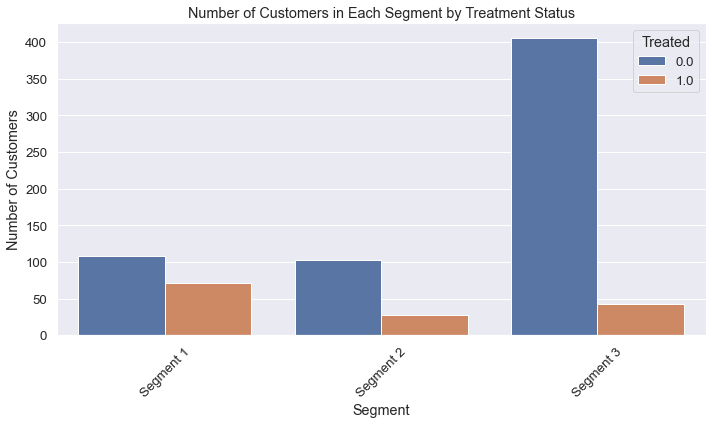

In [76]:
### Let's first see how many treated and not treated people are in each segment 

#Count the number of customers in each segment by treatment status
count_segment_treated = df.groupby(['segment', 'treated']).size().reset_index(name='count')

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=count_segment_treated, x='segment', y='count', hue='treated')

# Customize the plot
plt.title('Number of Customers in Each Segment by Treatment Status')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.legend(title='Treated', loc='upper right')
plt.tight_layout()

# Show the plot
plt.show()

In [77]:
### Segment 3 has a lot more customers that aren't targeted by the campaign

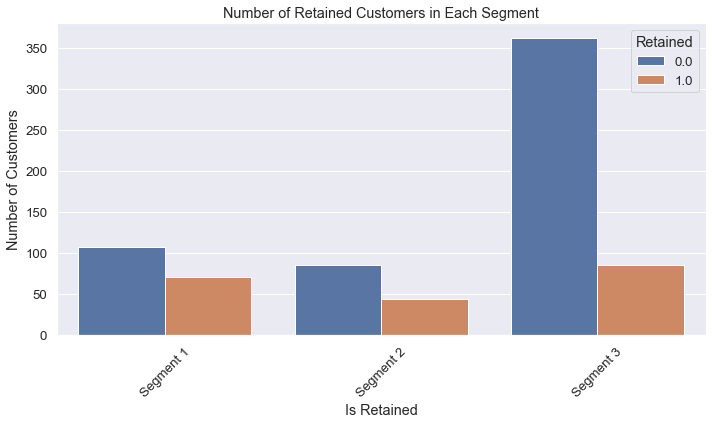

In [78]:
#Count the number of customers in each segment by treatment status
count_segment_outcome = df.groupby(['segment', 'outcome']).size().reset_index(name='count')

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=count_segment_outcome, x='segment', y='count', hue='outcome')

# Customize the plot
plt.title('Number of Retained Customers in Each Segment')
plt.xlabel('Is Retained')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.legend(title='Retained', loc='upper right')
plt.tight_layout()

# Show the plot
plt.show()

In [79]:
### Segment 3 also has more not retained users. Let's quickly check how many users are in these segments in general
df.segment.value_counts()

segment
Segment 3    447
Segment 1    179
Segment 2    130
Name: count, dtype: int64

In [80]:
## It seems like the treatment biased against Segment 3. Let's see if we can see why. Let's start with demographics
## and something that might be obvious - income, customer and app engagement, and then see other things like age, gender, subscription.
## We will first look at the dataset in general to see if there was a reason for the decision to assign the treatment this way

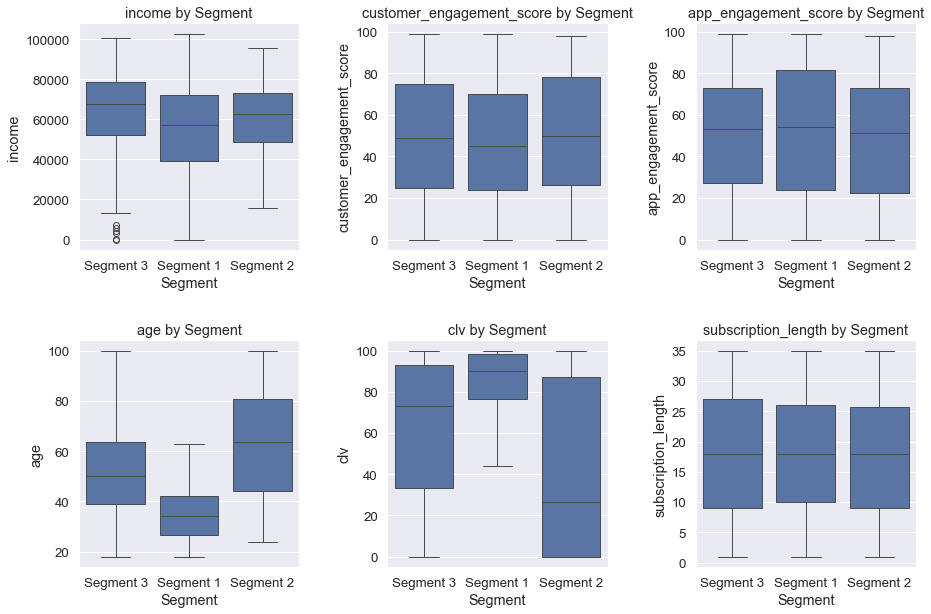

In [81]:
# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# List of columns to plot
columns_to_plot = ['income', 'customer_engagement_score', 'app_engagement_score', 'age', 'clv', 'subscription_length']

# Plot each column in a separate subplot
for ax, column in zip(axes.flatten(), columns_to_plot):
    sns.boxplot(data=df, x='segment', y=column, ax=ax)
    ax.set_title(f'{column} by Segment')
    ax.set_xlabel('Segment')
    ax.set_ylabel(column)

plt.show()

In [82]:
## One clue might be that segment 3 might not need help with retention - they have relatively high average income,
## are around 50, and have relatively high average clv. Let's see gender and life phase

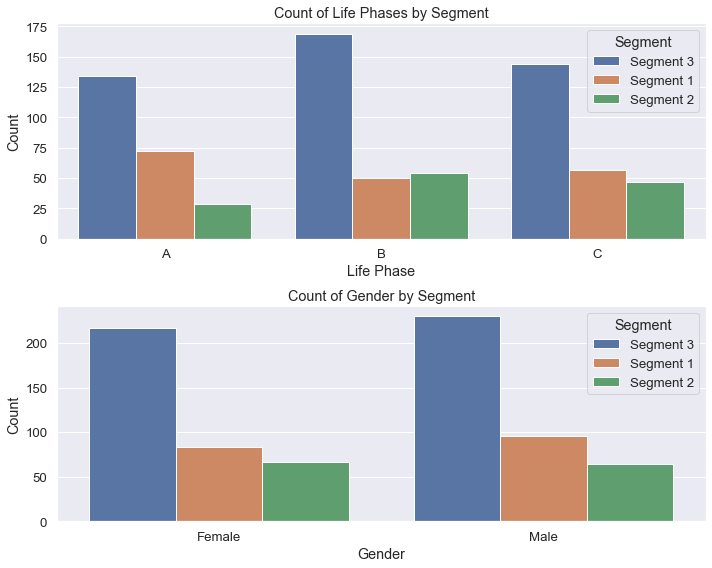

In [83]:
# Set up the figure and axes
fig, axes = plt.subplots(2, 1, figsize=(10, 8))  

# Count plot for life_phase
sns.countplot(x='life_phase', hue='segment', data=df, ax=axes[0])
axes[0].set_title('Count of Life Phases by Segment')
axes[0].set_xlabel('Life Phase')
axes[0].set_ylabel('Count')
axes[0].legend(title='Segment')

# Count plot for app_engagement_score
sns.countplot(x='gender', hue='segment', data=df, ax=axes[1])
axes[1].set_title('Count of Gender by Segment')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Count')
axes[1].legend(title='Segment')

# Adjust layout
plt.tight_layout()
plt.show()

In [84]:
### Life phase doesn't tell us much, there are more people in Segment 3 but they are in all 3 life phases. Same for gender

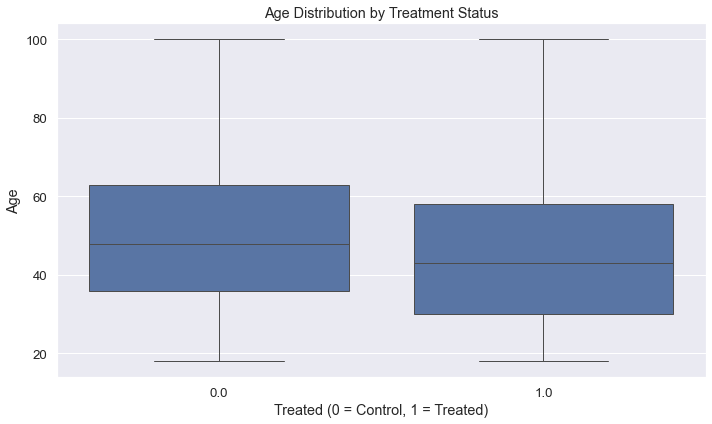

In [85]:
### Let's investigate further. Maybe we can say something like "who is receiving treatment, who is not, who is being retained
### and who is not". Who = how old are they, what gender they are, and what their income is. 

plt.figure(figsize=(10, 6))

# Create a box plot
sns.boxplot(x='treated', y='age', data=df)

# Set titles and labels
plt.title('Age Distribution by Treatment Status')
plt.xlabel('Treated (0 = Control, 1 = Treated)')
plt.ylabel('Age')

# Show the plot
plt.tight_layout()
plt.show()

In [86]:
## Similar ages but treated slightly younger, more variance in the older ages, and less variance in the younger.

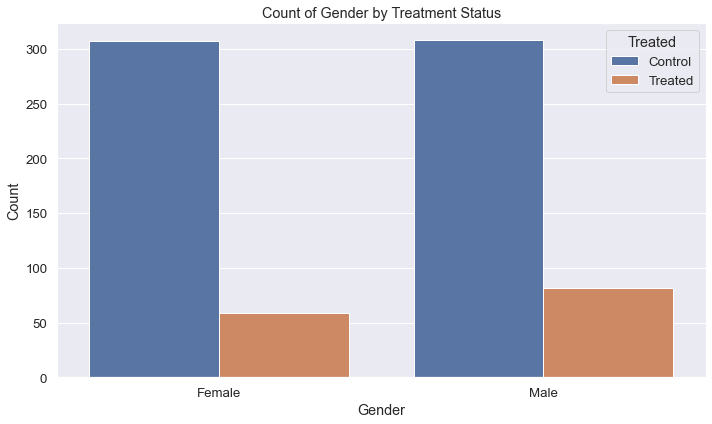

In [87]:
plt.figure(figsize=(10, 6))

# Create a count plot
sns.countplot(x='gender', hue='treated', data=df)

# Set titles and labels
plt.title('Count of Gender by Treatment Status')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Treated', labels=['Control', 'Treated'])

# Show the plot
plt.tight_layout()
plt.show()


In [88]:
### Slightly more men got the treatment, but pretty similar

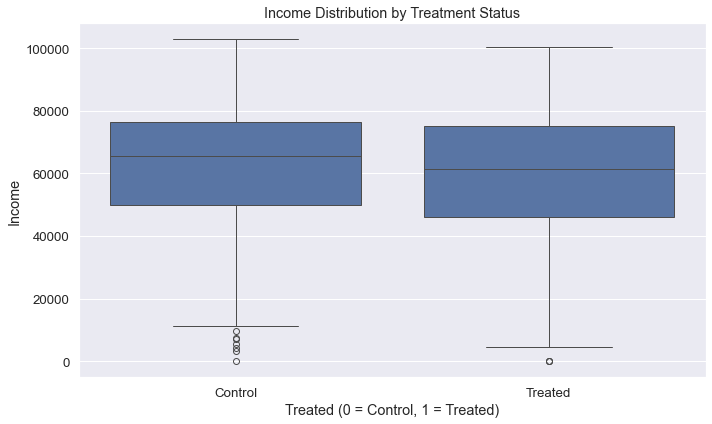

In [89]:
plt.figure(figsize=(10, 6))

# Create a box plot
sns.boxplot(x='treated', y='income', data=df)

# Set titles and labels
plt.title('Income Distribution by Treatment Status')
plt.xlabel('Treated (0 = Control, 1 = Treated)')
plt.ylabel('Income')

# Show the plot
plt.xticks(ticks=[0, 1], labels=['Control', 'Treated'])
plt.tight_layout()
plt.show()

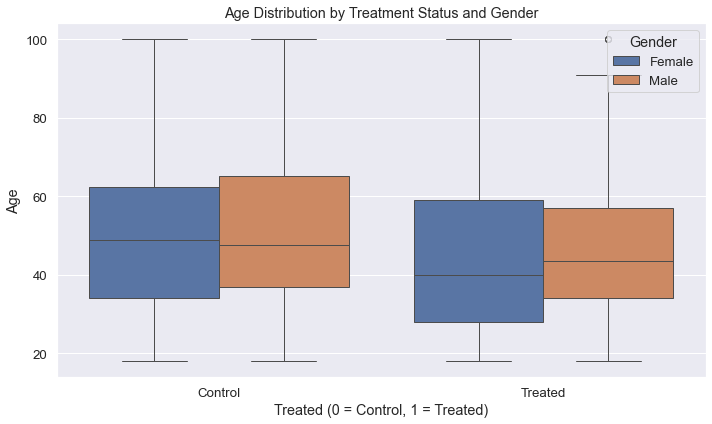

In [90]:
### Similar incomes although control has more customers that seem to have outliers for lower income. Let's start combining
### these characteristics


plt.figure(figsize=(10, 6))

# Create a box plot for age by treated status and gender
sns.boxplot(x='treated', y='age', hue='gender', data=df)

# Set titles and labels
plt.title('Age Distribution by Treatment Status and Gender')
plt.xlabel('Treated (0 = Control, 1 = Treated)')
plt.ylabel('Age')
plt.xticks(ticks=[0, 1], labels=['Control', 'Treated'])

# Show legend and adjust layout
plt.legend(title='Gender', loc='upper right')
plt.tight_layout()
plt.show()

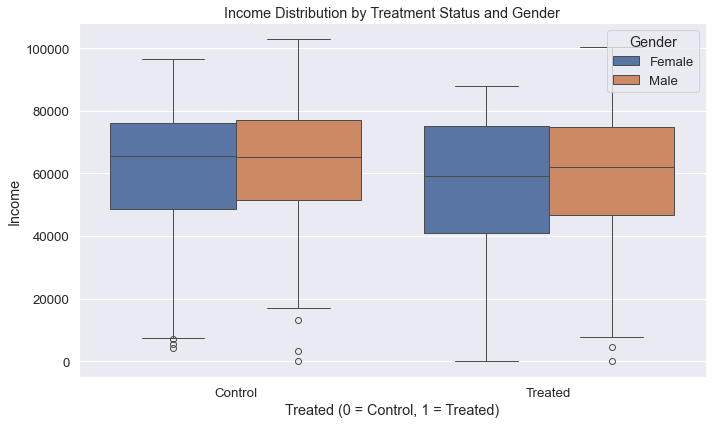

In [91]:
plt.figure(figsize=(10, 6))

# Create a box plot for age by treated status and gender
sns.boxplot(x='treated', y='income', hue='gender', data=df)

# Set titles and labels
plt.title('Income Distribution by Treatment Status and Gender')
plt.xlabel('Treated (0 = Control, 1 = Treated)')
plt.ylabel('Income')
plt.xticks(ticks=[0, 1], labels=['Control', 'Treated'])

# Show legend and adjust layout
plt.legend(title='Gender', loc='upper right')
plt.tight_layout()
plt.show()

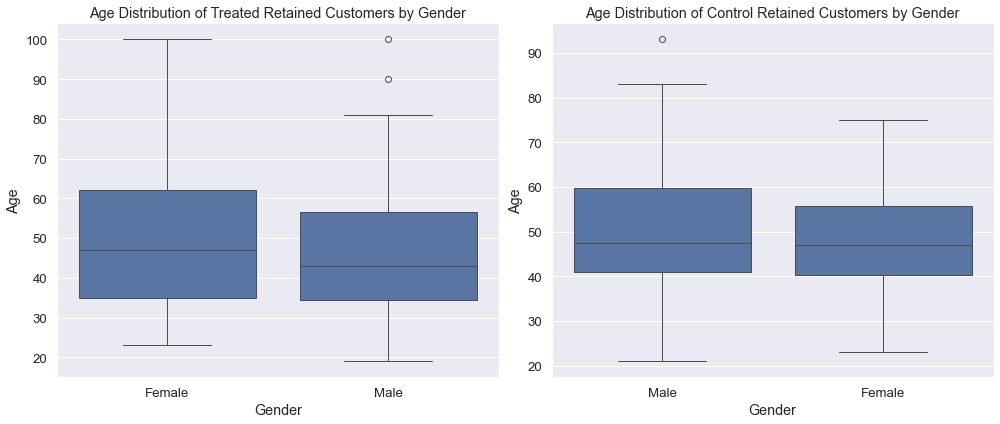

In [92]:
### Fairly similar people got the treatments. Now let's do the same visual checks but see a different cohort:
### retained from the treatment and retained organically: treated_retained vs control_retained

# Size of the plots
plt.figure(figsize=(14, 6))

# Create the first boxplot for treated retained customers
plt.subplot(1, 2, 1)  # specifies how many rows and columns the grid will have
sns.boxplot(x='gender', y='age', data=treated_retained)
plt.title('Age Distribution of Treated Retained Customers by Gender')
plt.xlabel('Gender')
plt.ylabel('Age')

# Create the second boxplot for control retained customers
plt.subplot(1, 2, 2)  
sns.boxplot(x='gender', y='age', data=control_retained)
plt.title('Age Distribution of Control Retained Customers by Gender')
plt.xlabel('Gender')
plt.ylabel('Age')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

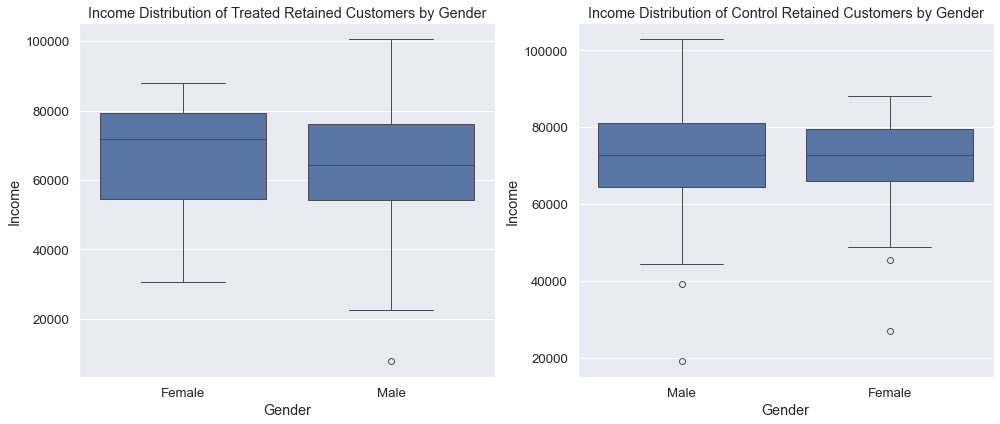

In [93]:
# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Create the first boxplot for treated retained customers
plt.subplot(1, 2, 1)  
sns.boxplot(x='gender', y='income', data=treated_retained)
plt.title('Income Distribution of Treated Retained Customers by Gender')
plt.xlabel('Gender')
plt.ylabel('Income')

# Create the second boxplot for control retained customers
plt.subplot(1, 2, 2)  
sns.boxplot(x='gender', y='income', data=control_retained)
plt.title('Income Distribution of Control Retained Customers by Gender')
plt.xlabel('Gender')
plt.ylabel('Income')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

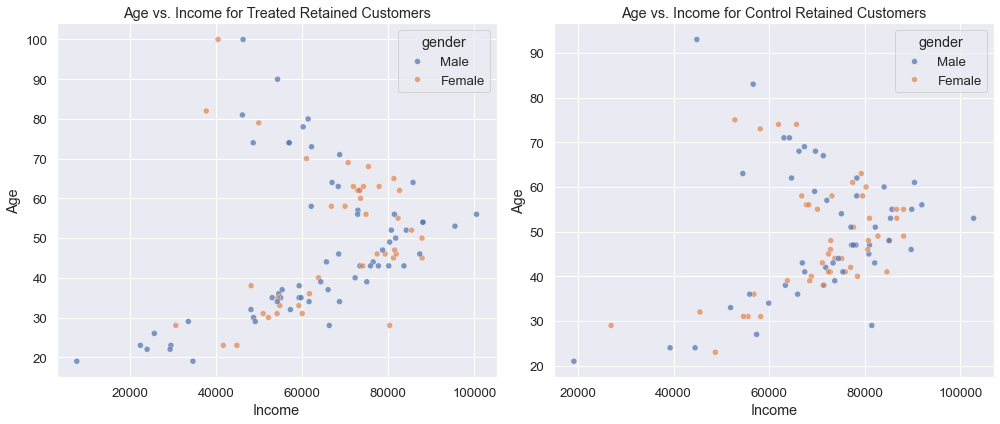

In [94]:
# Scatter plot for Age vs. Income for Treated Retained

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1) 
sns.scatterplot(x='income', y='age', data=treated_retained, hue='gender', hue_order=['Male', 'Female'], alpha=0.7)
plt.title('Age vs. Income for Treated Retained Customers')
plt.xlabel('Income')
plt.ylabel('Age')

# Scatter plot for Age vs. Income for Control Retained
plt.subplot(1, 2, 2)  
sns.scatterplot(x='income', y='age', data=control_retained, hue='gender', hue_order=['Male', 'Female'], alpha=0.7)
plt.title('Age vs. Income for Control Retained Customers')
plt.xlabel('Income')
plt.ylabel('Age')


# Adjust layout and show the plots
plt.tight_layout()
plt.show()

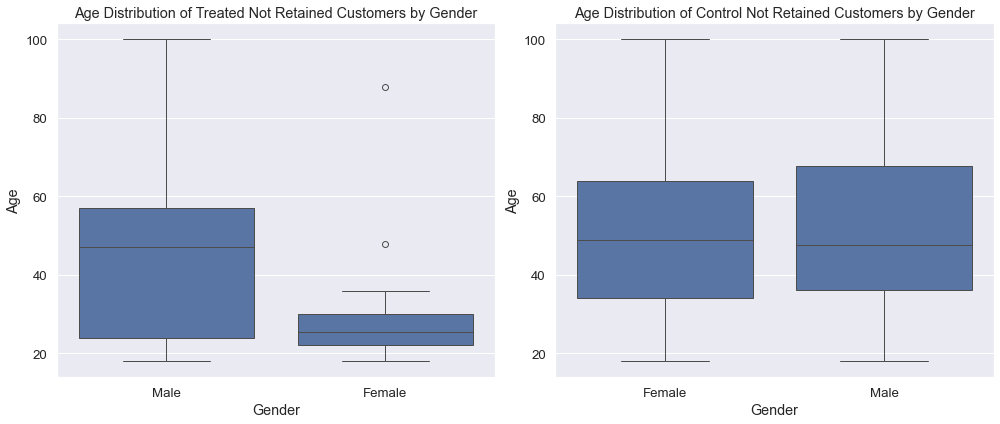

In [95]:
### The people that got retained from the campaign and organically seem to be similar. Let's check the people who were
### not retained

plt.figure(figsize=(14, 6))

# Create the first boxplot for treated retained customers
plt.subplot(1, 2, 1) 
sns.boxplot(x='gender', y='age', data=treated_not_retained)
plt.title('Age Distribution of Treated Not Retained Customers by Gender')
plt.xlabel('Gender')
plt.ylabel('Age')

# Create the second boxplot for control retained customers
plt.subplot(1, 2, 2)  
sns.boxplot(x='gender', y='age', data=control_not_retained)
plt.title('Age Distribution of Control Not Retained Customers by Gender')
plt.xlabel('Gender')
plt.ylabel('Age')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [96]:
### Female customers who got the treatment and were not retained were much younger than their male counterparts. 
### The control group seems to not have this bias. Could this signal an issue with the campaign for this segment?

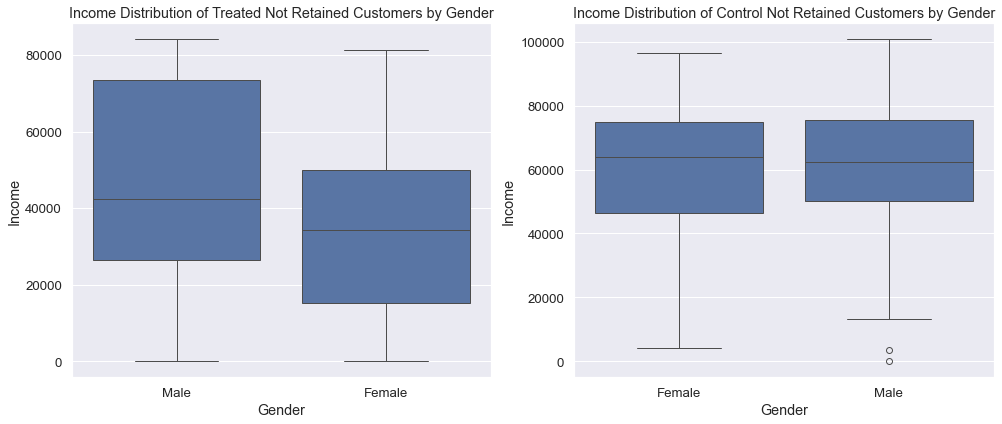

In [97]:
plt.figure(figsize=(14, 6))

# Create the first boxplot for treated retained customers
plt.subplot(1, 2, 1) 
sns.boxplot(x='gender', y='income', data=treated_not_retained)
plt.title('Income Distribution of Treated Not Retained Customers by Gender')
plt.xlabel('Gender')
plt.ylabel('Income')

# Create the second boxplot for control retained customers
plt.subplot(1, 2, 2) 
sns.boxplot(x='gender', y='income', data=control_not_retained)
plt.title('Income Distribution of Control Not Retained Customers by Gender')
plt.xlabel('Gender')
plt.ylabel('Income')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [98]:
### Female customers who saw the campaign and were not retained had lower income than their male counterparts.
### The control group who were not retained does not show the same pattern.

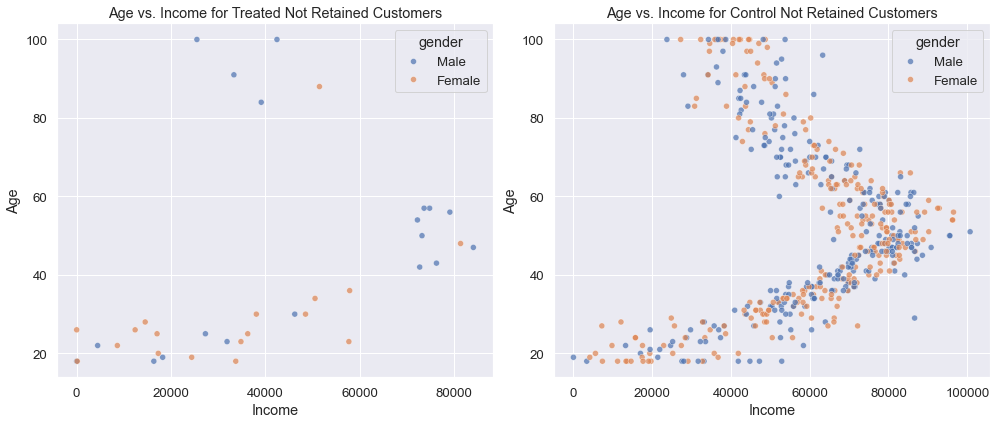

In [99]:
#Scatter plot for Age vs. Income for Treated Retained

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)  
sns.scatterplot(x='income', y='age', data=treated_not_retained, hue='gender', hue_order=['Male', 'Female'], alpha=0.7)
plt.title('Age vs. Income for Treated Not Retained Customers')
plt.xlabel('Income')
plt.ylabel('Age')

# Scatter plot for Age vs. Income for Control Retained
plt.subplot(1, 2, 2)  
sns.scatterplot(x='income', y='age', data=control_not_retained, hue='gender', hue_order=['Male', 'Female'], alpha=0.7)
plt.title('Age vs. Income for Control Not Retained Customers')
plt.xlabel('Income')
plt.ylabel('Age')


# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [100]:
## The left scatterplot shows that women that are not retained are younger and have a smaller range of age but their
## income varies. Some not retained men have income in the mid-range but are much older, and some men with high income
## between 40-60 are not retained. So perhaps this campaign shoudln't run for affluent middle-aged men and young-to-midlife (can't think
## of a word for ~40) women?

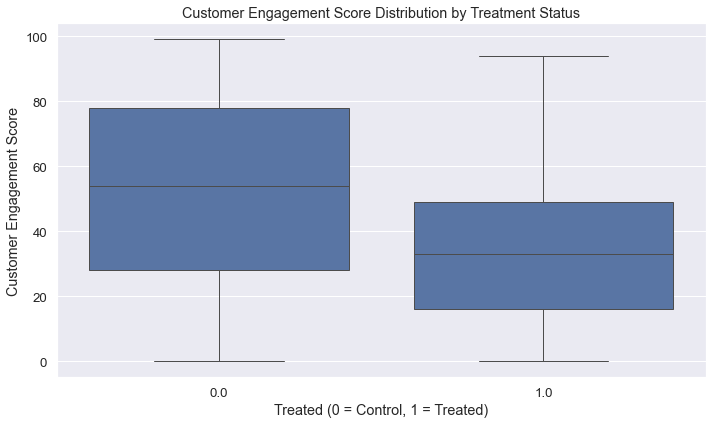

In [101]:
### Let's switch to another angle and try to answer the question: "how are people who received the treatment using the app,
### what is their engagement level, how long have they been subscriped for."

plt.figure(figsize=(10, 6))

# Create a box plot
sns.boxplot(x='treated', y='customer_engagement_score', data=df)

# Set titles and labels
plt.title('Customer Engagement Score Distribution by Treatment Status')
plt.xlabel('Treated (0 = Control, 1 = Treated)')
plt.ylabel('Customer Engagement Score')

# Show the plot
plt.tight_layout()
plt.show()

In [102]:
### This chart could provide an insight into the treatment intention - customers who got the treatment are less engaged

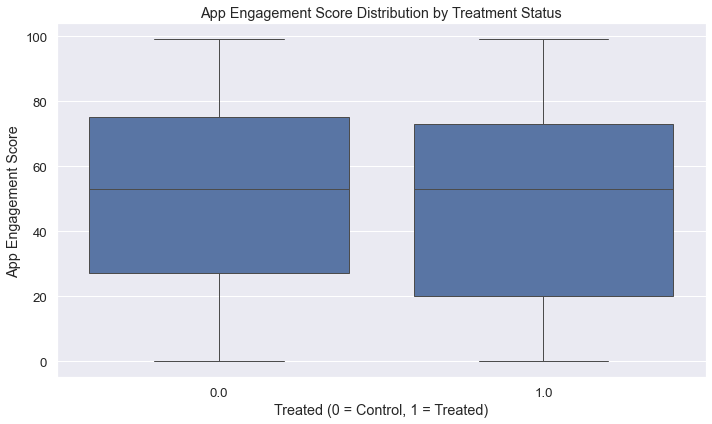

In [103]:
plt.figure(figsize=(10, 6))

# Create a box plot
sns.boxplot(x='treated', y='app_engagement_score', data=df)

# Set titles and labels
plt.title('App Engagement Score Distribution by Treatment Status')
plt.xlabel('Treated (0 = Control, 1 = Treated)')
plt.ylabel('App Engagement Score')

# Show the plot
plt.tight_layout()
plt.show()

In [104]:
### App engagement doesn't tell much, and neither does subscription length

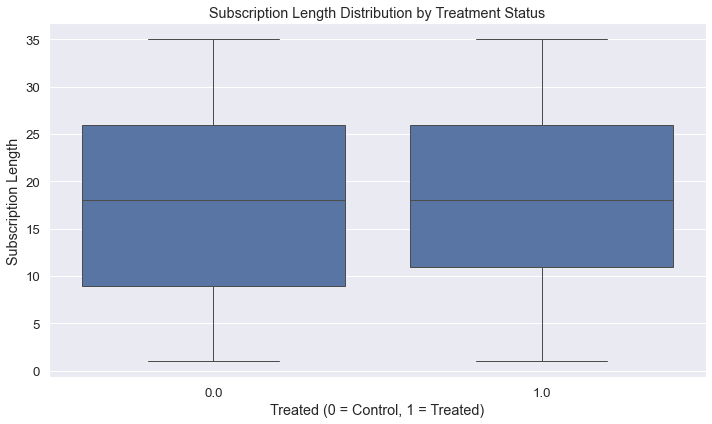

In [105]:
plt.figure(figsize=(10, 6))

# Create a box plot
sns.boxplot(x='treated', y='subscription_length', data=df)

# Set titles and labels
plt.title('Subscription Length Distribution by Treatment Status')
plt.xlabel('Treated (0 = Control, 1 = Treated)')
plt.ylabel('Subscription Length')

# Show the plot
plt.tight_layout()
plt.show()

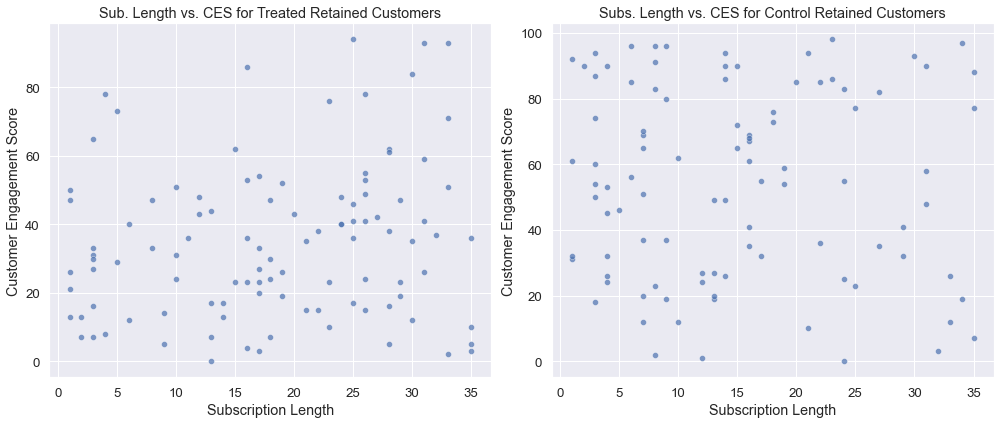

In [106]:
### Let's break these down by the four segments:

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)  
sns.scatterplot(x='subscription_length', y='customer_engagement_score', data=treated_retained, alpha=0.7)
plt.title('Sub. Length vs. CES for Treated Retained Customers')
plt.xlabel('Subscription Length')
plt.ylabel('Customer Engagement Score')

# Scatter plot for Age vs. Income for Control Retained
plt.subplot(1, 2, 2)  
sns.scatterplot(x='subscription_length', y='customer_engagement_score', data=control_retained, alpha=0.7)
plt.title('Subs. Length vs. CES for Control Retained Customers')
plt.xlabel('Subscription Length')
plt.ylabel('Customer Engagement Score')


# Adjust layout and show the plots
plt.tight_layout()
plt.show()

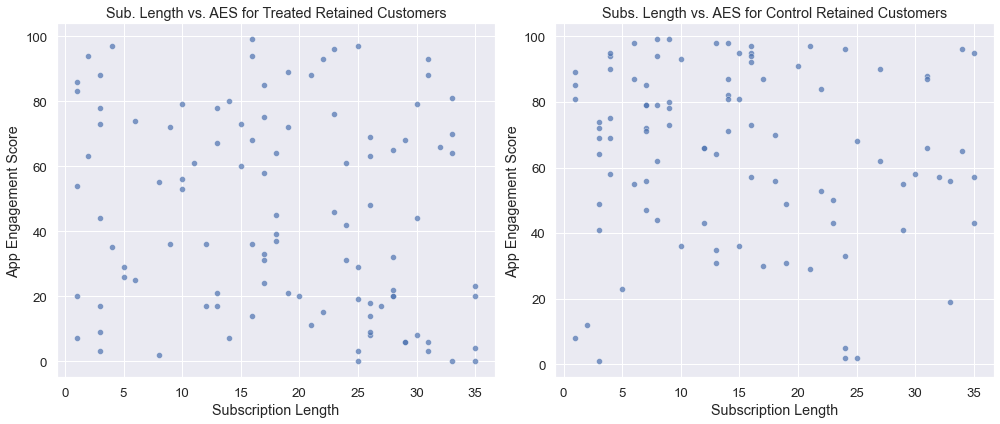

In [107]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)  
sns.scatterplot(x='subscription_length', y='app_engagement_score', data=treated_retained, alpha=0.7)
plt.title('Sub. Length vs. AES for Treated Retained Customers')
plt.xlabel('Subscription Length')
plt.ylabel('App Engagement Score')

# Scatter plot for Age vs. Income for Control Retained
plt.subplot(1, 2, 2) 
sns.scatterplot(x='subscription_length', y='app_engagement_score', data=control_retained, alpha=0.7)
plt.title('Subs. Length vs. AES for Control Retained Customers')
plt.xlabel('Subscription Length')
plt.ylabel('App Engagement Score')


# Adjust layout and show the plots
plt.tight_layout()
plt.show()

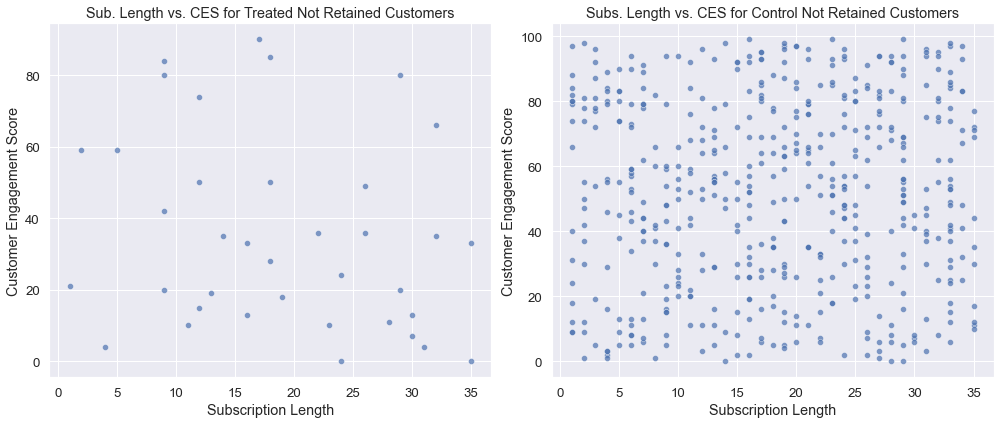

In [108]:
### Let's break these down by the four segments:

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)  
sns.scatterplot(x='subscription_length', y='customer_engagement_score', data=treated_not_retained, alpha=0.7)
plt.title('Sub. Length vs. CES for Treated Not Retained Customers')
plt.xlabel('Subscription Length')
plt.ylabel('Customer Engagement Score')

# Scatter plot for Age vs. Income for Control Retained
plt.subplot(1, 2, 2) 
sns.scatterplot(x='subscription_length', y='customer_engagement_score', data=control_not_retained, alpha=0.7)
plt.title('Subs. Length vs. CES for Control Not Retained Customers')
plt.xlabel('Subscription Length')
plt.ylabel('Customer Engagement Score')


# Adjust layout and show the plots
plt.tight_layout()
plt.show()

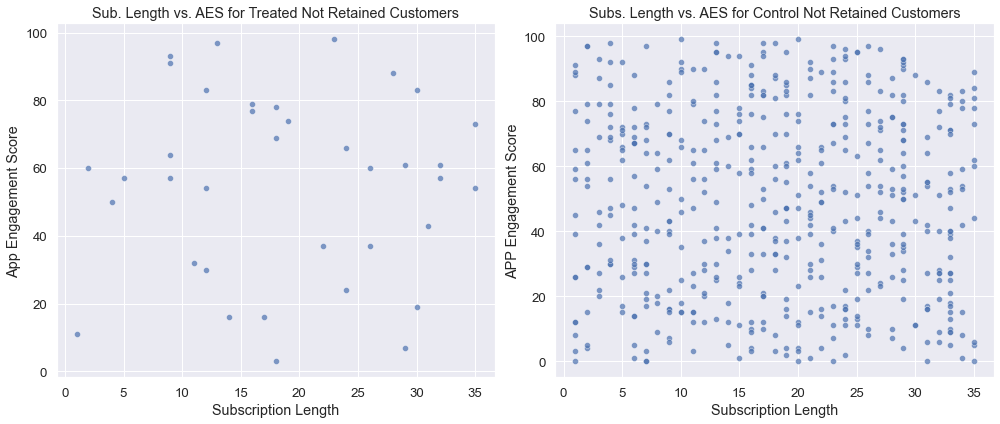

In [109]:
# Set up the matplotlib figure
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)  
sns.scatterplot(x='subscription_length', y='app_engagement_score', data=treated_not_retained, alpha=0.7)
plt.title('Sub. Length vs. AES for Treated Not Retained Customers')
plt.xlabel('Subscription Length')
plt.ylabel('App Engagement Score')

# Scatter plot for Age vs. Income for Control Retained
plt.subplot(1, 2, 2)  
sns.scatterplot(x='subscription_length', y='app_engagement_score', data=control_not_retained, alpha=0.7)
plt.title('Subs. Length vs. AES for Control Not Retained Customers')
plt.xlabel('Subscription Length')
plt.ylabel('APP Engagement Score')


# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [110]:
## The left-hand charts in the last two grids (Subscription length vs CES and AES) indicate that there could be a possibility
## to use these two columns to derive some sort of rule for the users who saw a treatment but weren't retained if we can
## fit a line that tells us when in the subscription life of a user to send them the campaign while monitoring their lifetime value
## (or just the subscription length, assuming clv is some sort of metric that includes subscription length)

In [111]:
## Let's see if there are differences in engagement between men and women
## We will first check the engagement of retained men and women

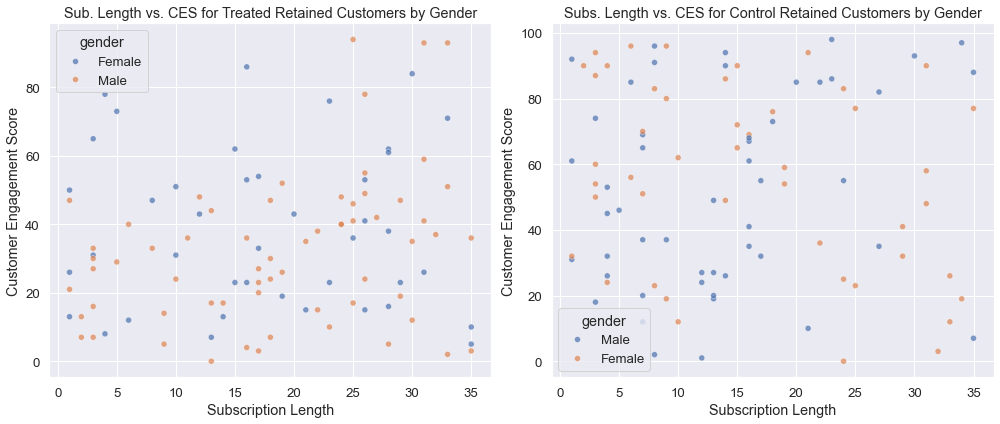

In [112]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)  
sns.scatterplot(x='subscription_length', y='customer_engagement_score', hue='gender', data=treated_retained, alpha=0.7)
plt.title('Sub. Length vs. CES for Treated Retained Customers by Gender')
plt.xlabel('Subscription Length')
plt.ylabel('Customer Engagement Score')

# Scatter plot for Age vs. Income for Control Retained
plt.subplot(1, 2, 2)  
sns.scatterplot(x='subscription_length', y='customer_engagement_score', hue='gender', data=control_retained, alpha=0.7)
plt.title('Subs. Length vs. CES for Control Retained Customers by Gender')
plt.xlabel('Subscription Length')
plt.ylabel('Customer Engagement Score')


# Adjust layout and show the plots
plt.tight_layout()
plt.show()

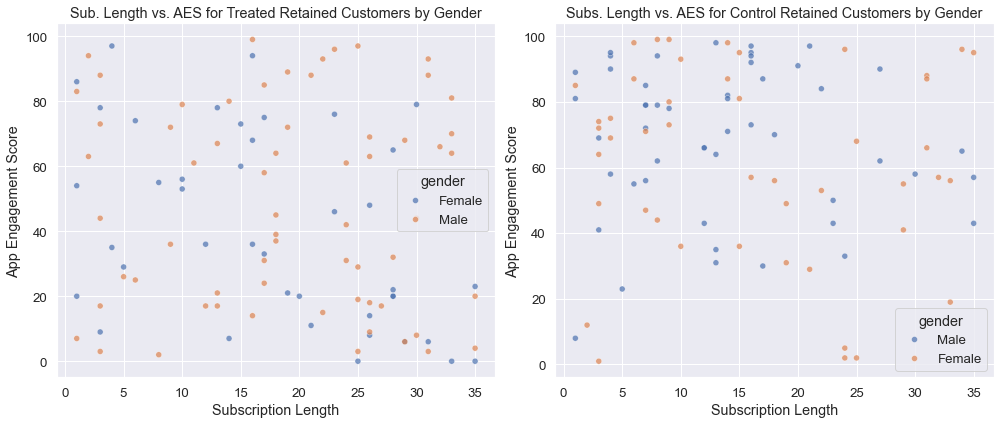

In [113]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1) 
sns.scatterplot(x='subscription_length', y='app_engagement_score', hue='gender', data=treated_retained, alpha=0.7)
plt.title('Sub. Length vs. AES for Treated Retained Customers by Gender')
plt.xlabel('Subscription Length')
plt.ylabel('App Engagement Score')

# Scatter plot for Age vs. Income for Control Retained
plt.subplot(1, 2, 2)  
sns.scatterplot(x='subscription_length', y='app_engagement_score', hue='gender', data=control_retained, alpha=0.7)
plt.title('Subs. Length vs. AES for Control Retained Customers by Gender')
plt.xlabel('Subscription Length')
plt.ylabel('App Engagement Score')


# Adjust layout and show the plots
plt.tight_layout()
plt.show()

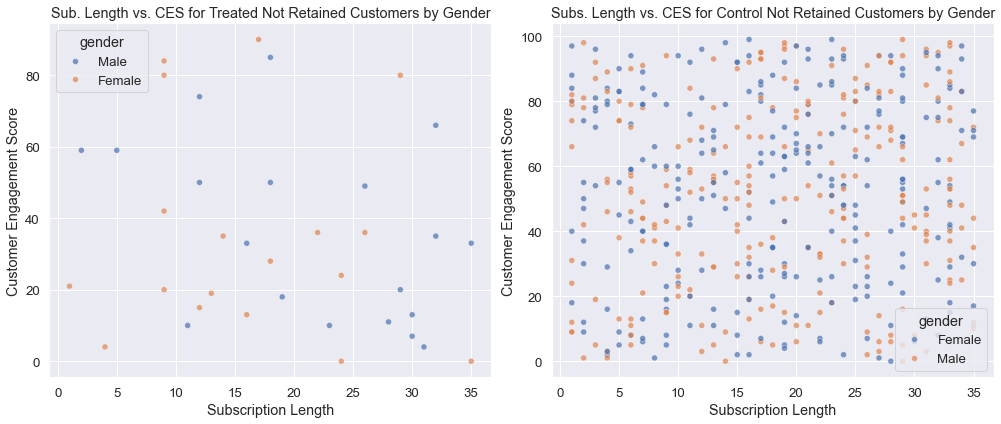

In [114]:
## Now we will check the engagement of not retained men and women
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x='subscription_length', y='customer_engagement_score', hue='gender', data=treated_not_retained, alpha=0.7)
plt.title('Sub. Length vs. CES for Treated Not Retained Customers by Gender')
plt.xlabel('Subscription Length')
plt.ylabel('Customer Engagement Score')

# Scatter plot for Age vs. Income for Control Retained
plt.subplot(1, 2, 2) 
sns.scatterplot(x='subscription_length', y='customer_engagement_score', hue='gender', data=control_not_retained, alpha=0.7)
plt.title('Subs. Length vs. CES for Control Not Retained Customers by Gender')
plt.xlabel('Subscription Length')
plt.ylabel('Customer Engagement Score')


# Adjust layout and show the plots
plt.tight_layout()
plt.show()

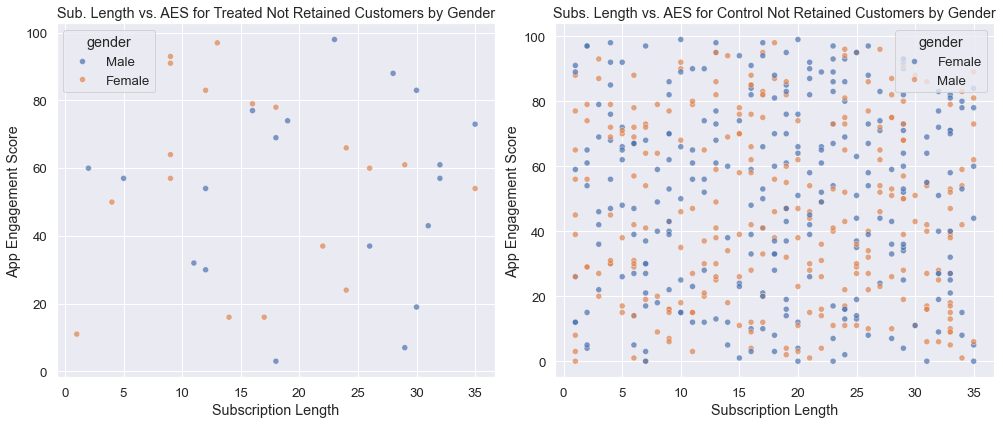

In [115]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)  
sns.scatterplot(x='subscription_length', y='app_engagement_score', hue='gender', data=treated_not_retained, alpha=0.7)
plt.title('Sub. Length vs. AES for Treated Not Retained Customers by Gender')
plt.xlabel('Subscription Length')
plt.ylabel('App Engagement Score')

# Scatter plot for Age vs. Income for Control Retained
plt.subplot(1, 2, 2)  
sns.scatterplot(x='subscription_length', y='app_engagement_score', hue='gender', data=control_not_retained, alpha=0.7)
plt.title('Subs. Length vs. AES for Control Not Retained Customers by Gender')
plt.xlabel('Subscription Length')
plt.ylabel('App Engagement Score')


# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [116]:
## Gender doesn't give us much additional information 

In [117]:
## Let's bin income and age to check them too

# Bin age and income for treated_not_retained using .loc[]
treated_retained.loc[:, 'age_bin'] = pd.cut(treated_retained['age'], bins=5, labels=['Very Young', 'Young', 'Middle Aged', 'Senior', 'Very Senior'])
treated_retained.loc[:, 'income_bin'] = pd.cut(treated_retained['income'], bins=5, labels=['Low Income', 'Lower-Middle Income', 'Middle Income', 'Upper-Middle Income', 'High Income'])

# Bin age and income for control_not_retained using .loc[]
control_retained.loc[:, 'age_bin'] = pd.cut(control_retained['age'], bins=5, labels=['Very Young', 'Young', 'Middle Aged', 'Senior', 'Very Senior'])
control_retained.loc[:, 'income_bin'] = pd.cut(control_retained['income'], bins=5, labels=['Low Income', 'Lower-Middle Income', 'Middle Income', 'Upper-Middle Income', 'High Income'])

/var/folders/90/4bx68z_n6bs2_mq1bj8j5_5c0000gn/T/ipykernel_2185/3631798090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treated_retained.loc[:, 'age_bin'] = pd.cut(treated_retained['age'], bins=5, labels=['Very Young', 'Young', 'Middle Aged', 'Senior', 'Very Senior'])
/var/folders/90/4bx68z_n6bs2_mq1bj8j5_5c0000gn/T/ipykernel_2185/3631798090.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treated_retained.loc[:, 'income_bin'] = pd.cut(treated_retained['income'], bins=5, labels=['Low Income', 'Low

/var/folders/90/4bx68z_n6bs2_mq1bj8j5_5c0000gn/T/ipykernel_2185/2543054080.py:5: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(x='subscription_length', y='app_engagement_score', hue='age_bin', data=treated_retained, palette=vibrant_palette, alpha=0.7)
/var/folders/90/4bx68z_n6bs2_mq1bj8j5_5c0000gn/T/ipykernel_2185/2543054080.py:12: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(x='subscription_length', y='app_engagement_score', hue='age_bin', data=control_retained, palette=vibrant_palette, alpha=0.7)


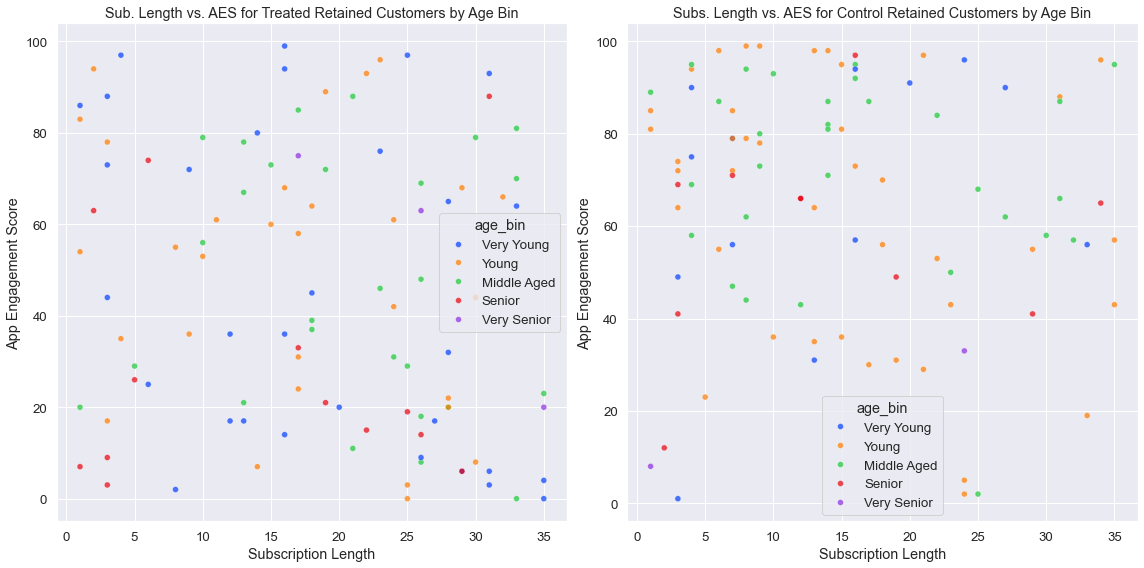

In [118]:
# Set up a vibrant color palette
vibrant_palette = sns.color_palette("bright")
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)  
sns.scatterplot(x='subscription_length', y='app_engagement_score', hue='age_bin', data=treated_retained, palette=vibrant_palette, alpha=0.7)
plt.title('Sub. Length vs. AES for Treated Retained Customers by Age Bin')
plt.xlabel('Subscription Length')
plt.ylabel('App Engagement Score')

# Scatter plot for Age vs. Income for Control Retained
plt.subplot(1, 2, 2) 
sns.scatterplot(x='subscription_length', y='app_engagement_score', hue='age_bin', data=control_retained, palette=vibrant_palette, alpha=0.7)
plt.title('Subs. Length vs. AES for Control Retained Customers by Age Bin')
plt.xlabel('Subscription Length')
plt.ylabel('App Engagement Score')


# Adjust layout and show the plots
plt.tight_layout()
plt.show()

/var/folders/90/4bx68z_n6bs2_mq1bj8j5_5c0000gn/T/ipykernel_2185/401100057.py:5: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(x='subscription_length', y='app_engagement_score', hue='income_bin', data=treated_retained, palette=vibrant_palette, alpha=0.7)
/var/folders/90/4bx68z_n6bs2_mq1bj8j5_5c0000gn/T/ipykernel_2185/401100057.py:12: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(x='subscription_length', y='app_engagement_score', hue='income_bin', data=control_retained, palette=vibrant_palette, alpha=0.7)


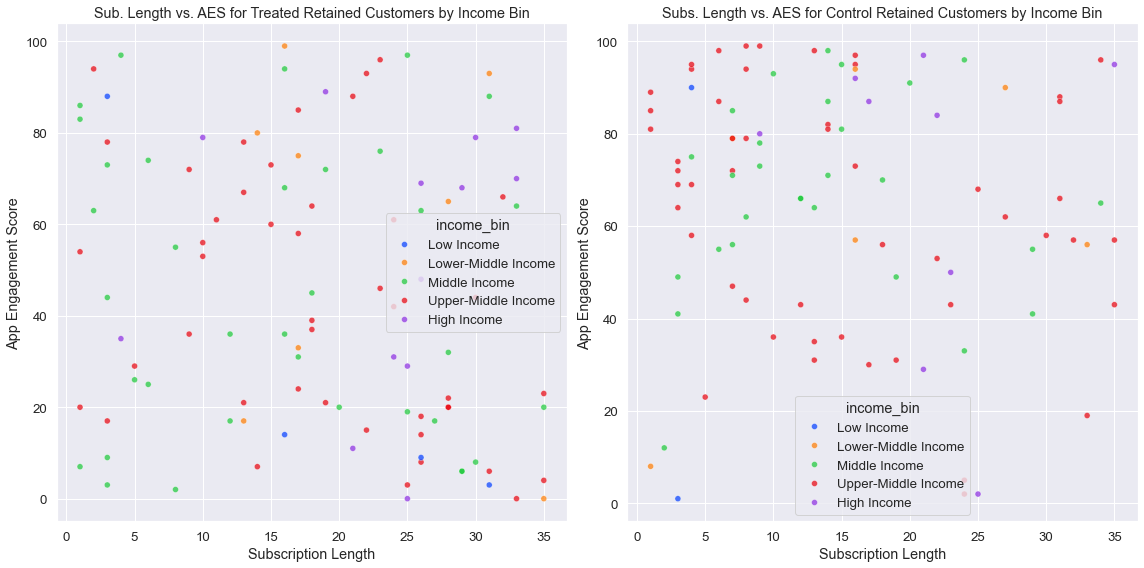

In [119]:
# Set up a vibrant color palette
vibrant_palette = sns.color_palette("bright")
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)  
sns.scatterplot(x='subscription_length', y='app_engagement_score', hue='income_bin', data=treated_retained, palette=vibrant_palette, alpha=0.7)
plt.title('Sub. Length vs. AES for Treated Retained Customers by Income Bin')
plt.xlabel('Subscription Length')
plt.ylabel('App Engagement Score')

# Scatter plot for Age vs. Income for Control Retained
plt.subplot(1, 2, 2)  
sns.scatterplot(x='subscription_length', y='app_engagement_score', hue='income_bin', data=control_retained, palette=vibrant_palette, alpha=0.7)
plt.title('Subs. Length vs. AES for Control Retained Customers by Income Bin')
plt.xlabel('Subscription Length')
plt.ylabel('App Engagement Score')


# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [120]:
## Let's bin income and age to check them too

# Bin age and income for treated_not_retained using .loc[]
treated_not_retained.loc[:, 'age_bin'] = pd.cut(treated_not_retained['age'], bins=5, labels=['Very Young', 'Young', 'Middle Aged', 'Senior', 'Very Senior'])
treated_not_retained.loc[:, 'income_bin'] = pd.cut(treated_not_retained['income'], bins=5, labels=['Low Income', 'Lower-Middle Income', 'Middle Income', 'Upper-Middle Income', 'High Income'])

# Bin age and income for control_not_retained using .loc[]
control_not_retained.loc[:, 'age_bin'] = pd.cut(control_not_retained['age'], bins=5, labels=['Very Young', 'Young', 'Middle Aged', 'Senior', 'Very Senior'])
control_not_retained.loc[:, 'income_bin'] = pd.cut(control_not_retained['income'], bins=5, labels=['Low Income', 'Lower-Middle Income', 'Middle Income', 'Upper-Middle Income', 'High Income'])


/var/folders/90/4bx68z_n6bs2_mq1bj8j5_5c0000gn/T/ipykernel_2185/3196760996.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treated_not_retained.loc[:, 'age_bin'] = pd.cut(treated_not_retained['age'], bins=5, labels=['Very Young', 'Young', 'Middle Aged', 'Senior', 'Very Senior'])
/var/folders/90/4bx68z_n6bs2_mq1bj8j5_5c0000gn/T/ipykernel_2185/3196760996.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treated_not_retained.loc[:, 'income_bin'] = pd.cut(treated_not_retained['income'], bins=5, labels=['L

/var/folders/90/4bx68z_n6bs2_mq1bj8j5_5c0000gn/T/ipykernel_2185/3689699420.py:5: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(x='subscription_length', y='app_engagement_score', hue='age_bin', data=treated_not_retained, palette=vibrant_palette, alpha=0.7)
/var/folders/90/4bx68z_n6bs2_mq1bj8j5_5c0000gn/T/ipykernel_2185/3689699420.py:12: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(x='subscription_length', y='app_engagement_score', hue='age_bin', data=control_not_retained, palette=vibrant_palette, alpha=0.7)


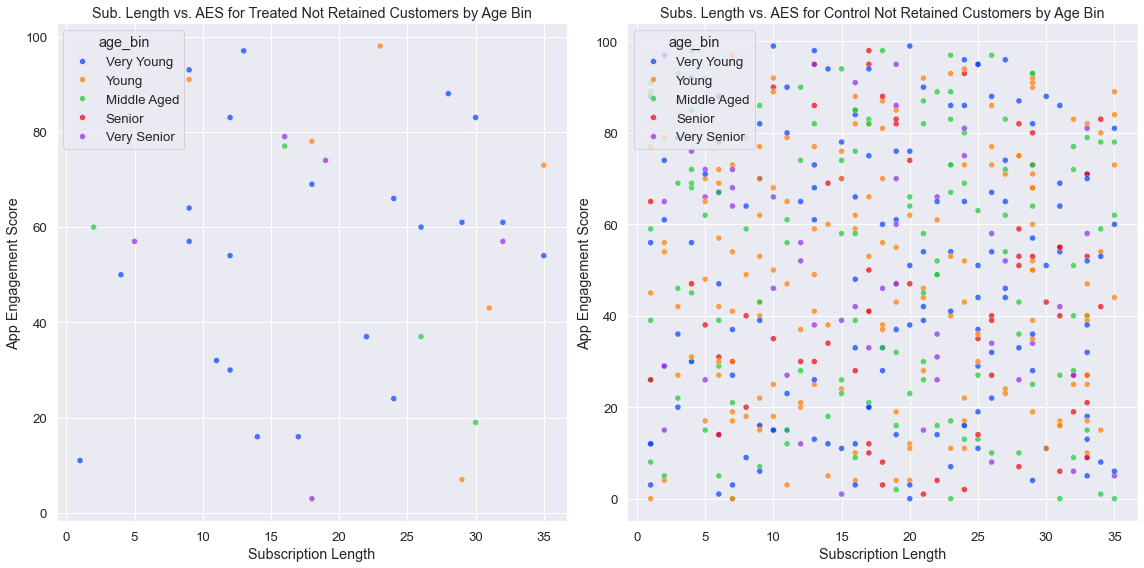

In [121]:
# Set up a vibrant color palette
vibrant_palette = sns.color_palette("bright")
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1) 
sns.scatterplot(x='subscription_length', y='app_engagement_score', hue='age_bin', data=treated_not_retained, palette=vibrant_palette, alpha=0.7)
plt.title('Sub. Length vs. AES for Treated Not Retained Customers by Age Bin')
plt.xlabel('Subscription Length')
plt.ylabel('App Engagement Score')

# Scatter plot for Age vs. Income for Control Retained
plt.subplot(1, 2, 2)  
sns.scatterplot(x='subscription_length', y='app_engagement_score', hue='age_bin', data=control_not_retained, palette=vibrant_palette, alpha=0.7)
plt.title('Subs. Length vs. AES for Control Not Retained Customers by Age Bin')
plt.xlabel('Subscription Length')
plt.ylabel('App Engagement Score')


# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [122]:
### Very young people tend to be mostly engaged but they are not retaining after seeing the campaign

/var/folders/90/4bx68z_n6bs2_mq1bj8j5_5c0000gn/T/ipykernel_2185/355926168.py:5: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(x='subscription_length', y='app_engagement_score', hue='income_bin', data=treated_not_retained, palette=vibrant_palette, alpha=0.7)
/var/folders/90/4bx68z_n6bs2_mq1bj8j5_5c0000gn/T/ipykernel_2185/355926168.py:12: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(x='subscription_length', y='app_engagement_score', hue='income_bin', data=control_not_retained, palette=vibrant_palette, alpha=0.7)


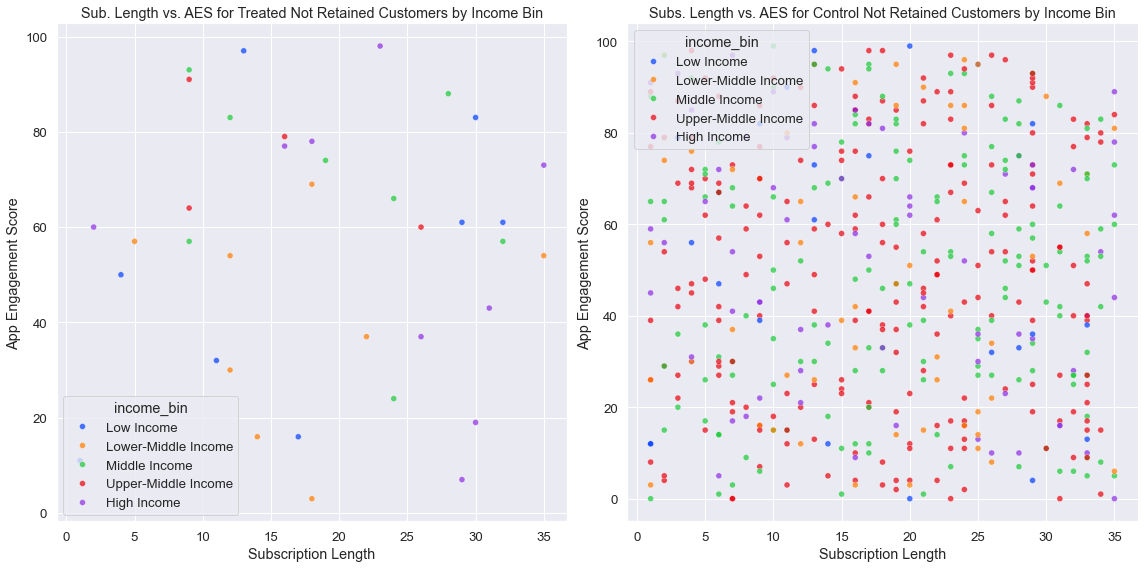

In [123]:
# Set up a vibrant color palette
vibrant_palette = sns.color_palette("bright")
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1) 
sns.scatterplot(x='subscription_length', y='app_engagement_score', hue='income_bin', data=treated_not_retained, palette=vibrant_palette, alpha=0.7)
plt.title('Sub. Length vs. AES for Treated Not Retained Customers by Income Bin')
plt.xlabel('Subscription Length')
plt.ylabel('App Engagement Score')

# Scatter plot for Age vs. Income for Control Retained
plt.subplot(1, 2, 2)  
sns.scatterplot(x='subscription_length', y='app_engagement_score', hue='income_bin', data=control_not_retained, palette=vibrant_palette, alpha=0.7)
plt.title('Subs. Length vs. AES for Control Not Retained Customers by Income Bin')
plt.xlabel('Subscription Length')
plt.ylabel('App Engagement Score')


# Adjust layout and show the plots
plt.tight_layout()
plt.show()

## Propensity Scores Techniques

In [124]:
# Let's initialize the logistic regression
log_reg = LogisticRegression()
log_reg.fit(X, df['treated'])  # fit the logistic regression model
df['propensity_score'] = log_reg.predict_proba(X)[:, 1] 

#### Nearest Neighbor Matching

In [125]:
# We are matching on these columns since we found indications they could be confounders

covariates = ['age', 'income', 'customer_engagement_score', 'app_engagement_score']

# Initialize logistic regression
model = LogisticRegression()
df['propensity_score'] = model.fit(df[covariates], df['treated']).predict_proba(df[covariates])[:,1]

# We use nearest neighbors to find matches for each treated unit
treated_ps = df[df['treated'] == 1]['propensity_score']
control_ps = df[df['treated'] == 0]['propensity_score']

In [126]:
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control_ps.values.reshape(-1, 1))

# Find the nearest neighbors (controls) for each treated unit
distances, indices = nn.kneighbors(treated_ps.values.reshape(-1, 1))

# Create a matched dataframe based on the nearest control for each treated unit
matched_control_indices = control_group.index[indices.flatten()]
matched_control = df.loc[matched_control_indices]

# Group treated and matched control into a df for visualization
matched_data = pd.concat([treatment_group, matched_control])

In [127]:
# Let's calculate SMDs again to make sure our covariates are balanced.
def calculate_smd(df, treated_col, covariates):
    """Function to calculate Standardized Mean Differences (SMD)"""
    smd = {}
    
    for col in covariates:
        treated_mean = treatment_group[col].mean()
        control_mean = control_group[col].mean()
        pooled_std = np.sqrt(((treatment_group[col].std()**2) + (control_group[col].std()**2)) / 2)
        smd[col] = (treated_mean - control_mean) / pooled_std
    
    return pd.DataFrame.from_dict(smd, orient='index', columns=['SMD'])



In [128]:
# Get the SMD for the matched data
smd_after_matching = calculate_smd(matched_data, 'treated', covariates)
print("SMD after Nearest Neighbor Matching:")
print(smd_after_matching)

SMD after Nearest Neighbor Matching:
                                SMD
age                       -0.247511
income                    -0.186363
customer_engagement_score -0.653019
app_engagement_score      -0.109092


In [129]:
ate = matched_data[matched_data['treated'] == 1]['outcome'].mean() - matched_data[matched_data['treated'] == 0]['outcome'].mean()
print("Estimated Average Treatment Effect (ATE):", ate)

Estimated Average Treatment Effect (ATE): 0.6666666666666666


In [130]:
## But what does this ATE number mean, is it significant? Let's check with bootstrapping
outcome = 'outcome'  
treatment = 'treated' 

# Number of bootstrap samples
n_bootstrap_samples = 1000
ate_bootstrap_samples = []

In [131]:
for _ in range(n_bootstrap_samples):
    # Sample with replacement
    sample = df.sample(frac=1, replace=True)
    
    # Calculate ATE for the bootstrap sample
    treated_outcome = sample[sample[treatment] == 1][outcome].mean()
    control_outcome = sample[sample[treatment] == 0][outcome].mean()
    
    ate_bootstrap_samples.append(treated_outcome - control_outcome)

# Calculate the mean ATE and the confidence interval
ate_mean = np.mean(ate_bootstrap_samples)
conf_interval = np.percentile(ate_bootstrap_samples, [2.5, 97.5])

In [132]:
print(f'Estimated Average Treatment Effect (ATE): {ate_mean}')
print(f'95% Confidence Interval for ATE: {conf_interval}')

Estimated Average Treatment Effect (ATE): 0.5821188626654598
95% Confidence Interval for ATE: [0.50978919 0.65401056]


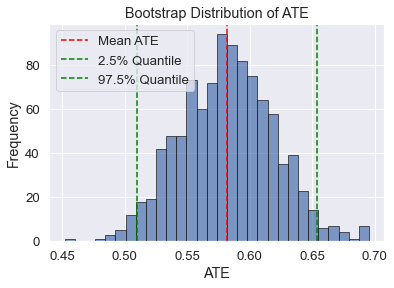

In [133]:
# Let's visualize the confidence intervals
plt.hist(ate_bootstrap_samples, bins=30, edgecolor='k', alpha=0.7)
plt.axvline(x=ate_mean, color='red', linestyle='--', label='Mean ATE')
plt.axvline(x=conf_interval[0], color='green', linestyle='--', label='2.5% Quantile')
plt.axvline(x=conf_interval[1], color='green', linestyle='--', label='97.5% Quantile')
plt.title('Bootstrap Distribution of ATE')
plt.xlabel('ATE')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [134]:
## Since our ATE is 0.66, this indicates that the treatment increases retention by about 0.66 units compared to the control group.
## The confidence interval suggests that we can be 95% confident that the true average treatment effect lies within this range.
## The lower bound interval means that in the least favorable scenario, the treatment is expected to improve the outcome by at least 0.5045 units.
## The upper nound interval means that in the most favorable scenario, tthe treatment is expected to improve the outcome by as much as 0.6579 units.


### Logistic Regression After Matching

In [135]:
X = matched_data[['treated', 'age', 'income', 'customer_engagement_score', 'app_engagement_score']]
y = matched_data['outcome'] 


In [136]:
# Add a constant to the model (intercept)
X = sm.add_constant(X)
# Fit the logistic regression model
model = sm.Logit(y, X)
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.359246
         Iterations 7


In [137]:
# Print the summary of the model
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                  282
Model:                          Logit   Df Residuals:                      276
Method:                           MLE   Df Model:                            5
Date:                Thu, 17 Oct 2024   Pseudo R-squ.:                  0.4675
Time:                        19:08:47   Log-Likelihood:                -101.31
converged:                       True   LL-Null:                       -190.27
Covariance Type:            nonrobust   LLR p-value:                 1.491e-36
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -5.2226      0.846     -6.176      0.000      -6.880      -3.565
treated                       4.1691      0.442      9.429      0.000       3.302     

# Next Steps
1. Experiment with different prices for different segments that have lower income
2. Experiment with the length of the subscription for different segments, at some point they could be subscribed for too long to not be affected by a campaign
3. Look at the subscription length together with the app engagement score to determine which segment to avoid marketing to
4. Segment 2 shows significant effect on outcome, we should investigate that
5. Perhaps we need other metrics to determine whether the treatment had effect: what happened after the customer was retained? Can we analyze their behavior and see if there are changes in how they use the app or their engagement score, or some other metric that isn't a proxy - time spent using the app/site before and after retention, generally insight into their user behavior
6. Female customers who got the treatment and were not retained were much younger than their male counterparts. The control group seems to not have this bias. Could this signal an issue with the campaign for this segment?
7. Female customers who got the treatment and were not retained had lower income than their male counterparts. The control group seems to not have this bias.
8. Look at subscription length to see at which point to send the campaign to increase the probability of being retained.
9. Combine the "who" and the "how engaged they are" to further develop the segments. 
10. Find segments of retained people in both treatment and control groups who are similar. The goal is to find out which users are likely to retain on their own, so we can spend money on people who need to be informed or persuaded to be retained.
11. We need to know the nature of the campaign and the retention process: were users able to opt out of the campaign and carry on with their intented action? Is there a difference between how treatment customers got retained and how control customers got retaiend on their own? Could there be a factor hidden here?

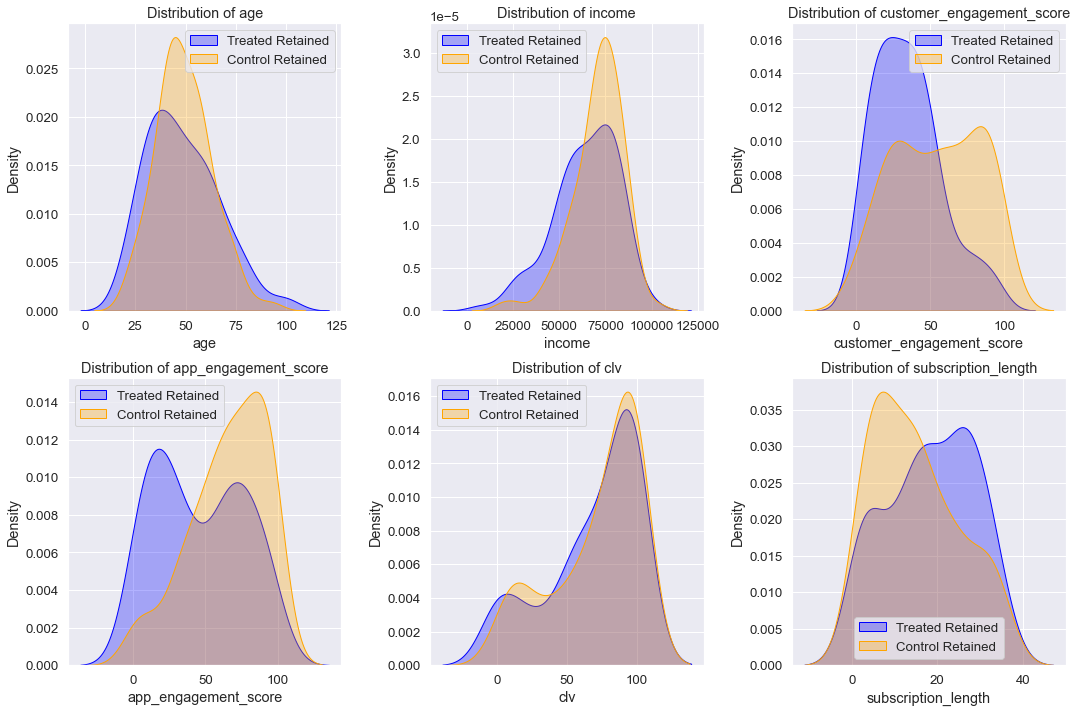

In [138]:
# This builds the last chart on slide 7 in Marketing Campaign Success PPT
columns_to_plot = ['age', 'income', 'customer_engagement_score', 'app_engagement_score', 'clv', 'subscription_length']

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Loop through the columns and create a subplot for each
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(2, 3, i)  # Create a grid of 2 rows and 3 columns
    # KDE for treated retained
    sns.kdeplot(data=treated_retained, x=column, fill=True, alpha=0.3, label='Treated Retained', color='blue')
    
    # KDE for control retained
    sns.kdeplot(data=control_retained, x=column, fill=True, alpha=0.3, label='Control Retained', color='orange')

    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()
